In [4]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [5]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest
# the following (used in Figure S16) require
# R to be installed along with R packages `lme4` and `lmerTest`
from pymer4.models import Lmer
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
lme4 = importr('lme4')

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
}
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)

from utils import transform, stats, plot
from modeling.check_fit import *

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"font.size": 12, "font.family": "Asana Math", "figure.dpi": 192})
thcolor = "#44546A"

Load the simulation data that was curated in Figure 2:

In [6]:
parcels = transform.load_ordered_parcel_labels('schaefer-100')
elig_subs = pd.read_csv('/data/project/PNC_processing/output/all_subjs_eligible_age_fs_fmri_dwi_240119_wPS_TD.csv', index_col=0).sort_index()
if os.path.exists('pnc_fc-sub_sc-sub_runs-2.csv') & os.path.exists('pnc_fc-sub_sc-sub_runs-2_vars.pkz'):
    subjects_optima = pd.read_csv('pnc_fc-sub_sc-sub_runs-2.csv', index_col=0)
    with open('pnc_fc-sub_sc-sub_runs-2_vars.pkz', 'rb') as f:
        regional_vars = pickle.load(f)
else:
    print("Run Fig_2.ipynb first")

best_runs = subjects_optima.groupby('sub')['gof'].idxmax().values
data = subjects_optima.loc[best_runs].set_index('sub')
data[['age', 'sex','group']] = elig_subs.loc[data.index,['age', 'sex','group']]
data['Age (y)'] = data['age'] / 12

# add motion data
motion = pd.read_csv('/data/project/PNC_processing/output/postfmriprep/participants.tsv', 
                     delimiter='\t', index_col=0).loc[data.index]
data = pd.concat([data, motion], axis=1)

# Figure S16. Association of $r^E$, $I^E$ and $\frac{S^E}{S^I}$ time series in the optimal simulation of an example subject

Randomly select a subject and re-run its simulation while saving the time series of model state variables:

In [7]:
np.random.seed(0)
sub = np.random.choice(data.index, 1)[0]
SeedMW = data.loc[sub, 'SeedMW']
print(sub, SeedMW)

sub-609135444969 1


In [ ]:
!python run_sim.py $sub $SeedMW

Load simulation data:

In [8]:
sim_data = np.load(
    os.path.join(
        os.environ["PNC_PROJECT_DIR"], "output",
        "sim", sub,
        "ctx_parc-schaefer-100_mean001_thresh-1",
        "6maps_schaefer-100_zscore", "cmaes_multimaps_gpu",
        f"ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass-none_exc-inter_G_0.5-4_wee_0.05-0.75_wei_0.05-0.75_wie_0_het-wee-wei_SeedMW-{SeedMW}_SeedSim-410_n-81x210_cuBNM",
        "ts", "it1.npz",
    ),
    allow_pickle=True,
)

## a. Time series of 3 randomly selected nodes

44 PearsonRResult(statistic=0.24186300072886444, pvalue=0.003859468108348129) PearsonRResult(statistic=0.9312989976284489, pvalue=7.862622024850882e-63)
47 PearsonRResult(statistic=0.5564792517639511, pvalue=7.799479176289784e-13) PearsonRResult(statistic=0.9278332093443271, pvalue=2.130400736835952e-61)
64 PearsonRResult(statistic=0.42830154533629833, pvalue=1.1700742290481072e-07) PearsonRResult(statistic=0.9677985921128887, pvalue=3.7378001715642833e-85)


Text(0.5, 0, 'Simulation time')

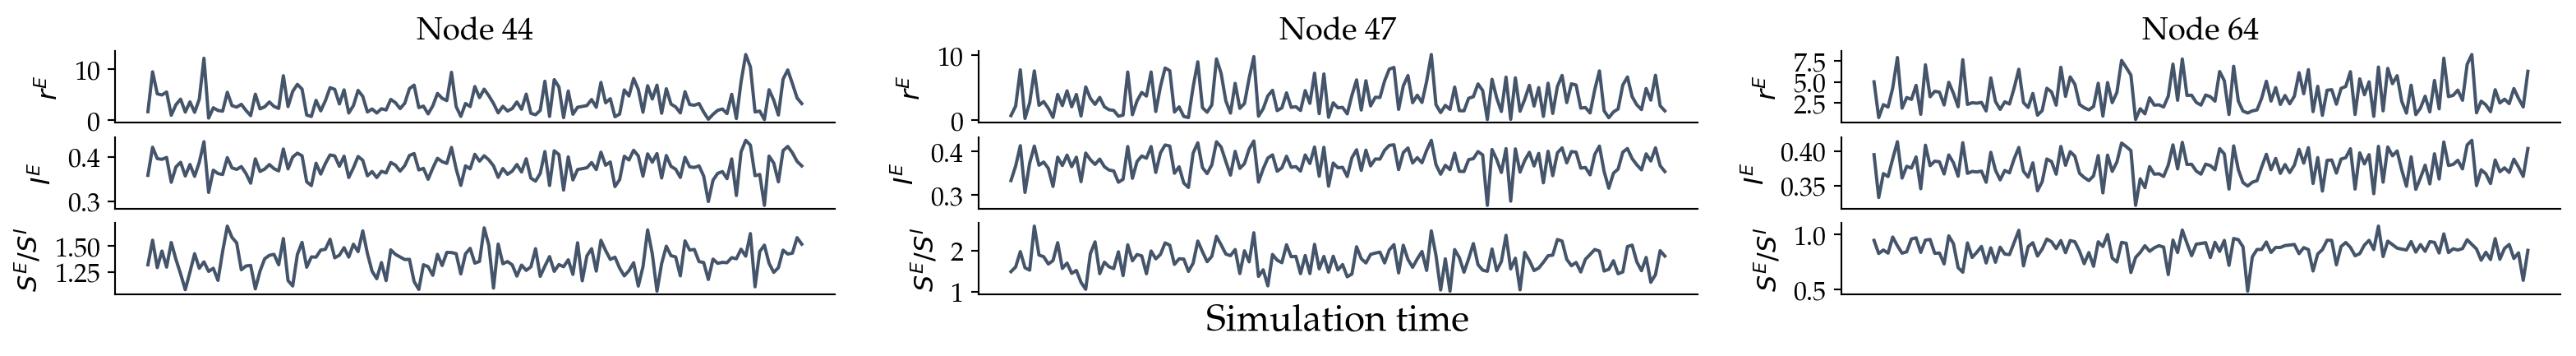

In [87]:
fig, axes = plt.subplots(3, 3, figsize=(20, 2))

clean_labels = {
    'r_E': r'$r^E$',
    'I_E': r'$I^E$',
    'S_ratio': r'$S^E/S^I$',
}

np.random.seed(0)

for j, node in enumerate(np.random.choice(100, 3)):
    ts = {}
    ts['I_E'] = sim_data["sim_states"].reshape(1)[0]["I_E"][0, 10:, node]
    ts['r_E'] = sim_data["sim_states"].reshape(1)[0]["r_E"][0, 10:, node]
    ts['S_E'] = sim_data["sim_states"].reshape(1)[0]["S_E"][0, 10:, node]
    ts['S_I'] = sim_data["sim_states"].reshape(1)[0]["S_I"][0, 10:, node]
    ts['S_ratio'] = ts['S_E'] / ts['S_I']
    ts_d = pd.DataFrame(ts)
    axes[0, j].set_title(f'Node {node}')
    for i, k in enumerate(['r_E', 'I_E', 'S_ratio']):
        axes[i,j].plot(ts_d[k], color=thcolor)
        axes[i,j].set_ylabel(clean_labels[k])
        if i < len(ts)-1:
            axes[i,j].set_xticks([])
        sns.despine()
    print(node, scipy.stats.pearsonr(ts['S_ratio'], ts['r_E']),scipy.stats.pearsonr(ts['I_E'], ts['r_E']))
axes[2,1].set_xlabel('Simulation time', fontsize=17)

## b. Associations of model states across nodes and time

### Fit models

In [9]:
long_df = pd.DataFrame({
    'r_E': sim_data["sim_states"].reshape(1)[0]["r_E"][0, 10:].T.flatten(),
    'I_E': sim_data["sim_states"].reshape(1)[0]["I_E"][0, 10:].T.flatten(),
    'S_ratio': (
            sim_data["sim_states"].reshape(1)[0]["S_E"][0, 10:] / 
            sim_data["sim_states"].reshape(1)[0]["S_I"][0, 10:]
        ).T.flatten(),
    'time': np.tile(np.arange(141), 100),
    'node': np.repeat(np.arange(100), 141)
})

# exclude upper 2.5% of S_ratio (including values approaching inf)
long_df = long_df.loc[long_df['S_ratio']<long_df['S_ratio'].quantile(0.975)]

# copy to R
long_df_r = pandas2ri.py2rpy(long_df)

In [10]:
residuals = {
    'Linear': {},
    'Log': {}
}

r2s = {
    'Linear': {},
    'Log': {}
}

AICs = {
    'Linear': {},
    'Log': {}
}

#### Linear

Using `pymer4`

$r^E$ ~ $I^E$

In [11]:
model = Lmer("r_E ~ I_E + (1 + I_E | node)", data=long_df)
print(model.fit())

Linear mixed model fit by REML [’lmerMod’]
Formula: r_E~I_E+(1+I_E|node)

Family: gaussian	 Inference: parametric

Number of observations: 13747	 Groups: {'node': 100.0}

Log-likelihood: -27964.729 	 AIC: 55941.459

Random effects:

                 Name      Var     Std
node      (Intercept)   24.393   4.939
node              I_E  201.643  14.200
Residual                 3.291   1.814

              IV1  IV2  Corr
node  (Intercept)  I_E -0.99

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)   -32.280 -33.319  -31.241  0.530  98.233 -60.907    0.0  ***
I_E            96.896  93.938   99.855  1.509  94.188  64.197    0.0  ***


In [18]:
r2 = 1 - (((model.residuals)**2).sum()) / (((long_df['r_E']-long_df['r_E'].mean())**2).sum())
r2

0.821657693968604

In [61]:
residuals['Linear']['r_E~I_E'] = model.residuals
r2s['Linear']['r_E~I_E'] = r2
AICs['Linear']['r_E~I_E'] = model.AIC

$r^E$ ~ $\frac{S^E}{S^I}$

In [19]:
model = Lmer("r_E ~ S_ratio + (1 + S_ratio | node)", data=long_df)
print(model.fit())

Linear mixed model fit by REML [’lmerMod’]
Formula: r_E~S_ratio+(1+S_ratio|node)

Family: gaussian	 Inference: parametric

Number of observations: 13747	 Groups: {'node': 100.0}

Log-likelihood: -34993.282 	 AIC: 69998.564

Random effects:

                 Name     Var    Std
node      (Intercept)  53.176  7.292
node          S_ratio  14.867  3.856
Residual                8.914  2.986

              IV1      IV2  Corr
node  (Intercept)  S_ratio -0.47

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)   -11.981 -13.466  -10.495  0.758  101.371 -15.806    0.0  ***
S_ratio         9.252   8.437   10.067  0.416   94.361  22.249    0.0  ***


In [20]:
r2 = 1 - (((model.residuals)**2).sum()) / (((long_df['r_E']-long_df['r_E'].mean())**2).sum())
r2

0.5171232228691346

In [64]:
residuals['Linear']['r_E~S_ratio'] = model.residuals
r2s['Linear']['r_E~S_ratio'] = r2
AICs['Linear']['r_E~S_ratio'] = model.AIC

$I^E$ ~ $\frac{S^E}{S^I}$

In [21]:
model = Lmer("I_E ~ S_ratio + (1 + S_ratio | node)", data=long_df)
print(model.fit())

Linear mixed model fit by REML [’lmerMod’]
Formula: I_E~S_ratio+(1+S_ratio|node)

Family: gaussian	 Inference: parametric

Number of observations: 13747	 Groups: {'node': 100.0}

Log-likelihood: 29822.816 	 AIC: -59633.632

Random effects:

                 Name    Var    Std
node      (Intercept)  0.004  0.062
node          S_ratio  0.001  0.033
Residual               0.001  0.027

              IV1      IV2   Corr
node  (Intercept)  S_ratio -0.269

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)     0.230   0.217    0.243  0.006  101.413  35.766    0.0  ***
S_ratio         0.084   0.077    0.091  0.004   89.435  23.589    0.0  ***


In [23]:
r2 = 1 - (((model.residuals)**2).sum()) / (((long_df['I_E']-long_df['I_E'].mean())**2).sum())
r2

0.47241099371658557

In [67]:
residuals['Linear']['I_E~S_ratio'] = model.residuals
r2s['Linear']['I_E~S_ratio'] = r2
AICs['Linear']['I_E~S_ratio'] = model.AIC

#### With logarithmic linking

This is not supported in `pymer4`, therefore it will be done directly using R via `rpy2` interface and usign `lme4` package.

$r^E$ ~ $I^E$

In [52]:
%%time
model = lme4.glmer("r_E ~ I_E + (1 + I_E | node)", data=long_df_r, family=robjects.r.gaussian(link = "log"), verbose=False)
# suppress the printing of data in summary
model.do_slot_assign('call', None)
print(robjects.r.summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: gaussian  ( log )

     AIC      BIC   logLik deviance df.resid 
 28142.7  28187.9 -14065.3  28130.7    13741 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-13.7821  -0.6288  -0.2352   0.2389   8.2656 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 node     (Intercept) 0.8333   0.9129        
          I_E         4.9766   2.2308   -1.00
 Residual             0.4408   0.6639        
Number of obs: 13747, groups:  node, 100

Fixed effects:
            Estimate Std. Error t value Pr(>|z|)    
(Intercept)  -7.3740     0.1375  -53.61   <2e-16 ***
I_E          22.7314     0.3362   67.61   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
I_E -1.000

CPU times: user 5.57 s, sys: 15 ms, total: 5.59 s
Wall time: 5.64 s


In [53]:
residual = pd.Series(robjects.r.residuals(model, type="response"), index=long_df.index)

In [54]:
r2 = 1 - ((residual**2).sum()) / (((long_df['r_E']-long_df['r_E'].mean())**2).sum())
r2

0.9763445112723456

In [55]:
residuals['Log']['r_E~I_E'] = residual
r2s['Log']['r_E~I_E'] = r2
AICs['Log']['r_E~I_E'] = robjects.r.AIC(model)[0]

$r^E$ ~ $\frac{S^E}{S^I}$

In [56]:
%%time
model = lme4.glmer("r_E ~ S_ratio + (1 + S_ratio | node)", data=long_df_r, family=robjects.r.gaussian(link = "log"), verbose=False)
# suppress the printing of data in summary
model.do_slot_assign('call', None)
print(robjects.r.summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: gaussian  ( log )

     AIC      BIC   logLik deviance df.resid 
 68476.5  68521.6 -34232.2  68464.5    13741 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.8380 -0.6319 -0.2017  0.4019  8.2722 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 node     (Intercept) 10.221   3.197         
          S_ratio     14.050   3.748    -0.73
 Residual              7.636   2.763         
Number of obs: 13747, groups:  node, 100

Fixed effects:
            Estimate Std. Error t value Pr(>|z|)    
(Intercept)  -2.4669     0.1192  -20.70   <2e-16 ***
S_ratio       2.4624     0.1373   17.94   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
S_ratio -0.732

CPU times: user 1.35 s, sys: 3.91 ms, total: 1.35 s
Wall time: 1.4 s


In [57]:
residual = pd.Series(robjects.r.residuals(model, type="response"), index=long_df.index)

In [58]:
r2 = 1 - ((residual**2).sum()) / (((long_df['r_E']-long_df['r_E'].mean())**2).sum())
r2

0.5815395670906152

In [59]:
residuals['Log']['r_E~S_ratio'] = residual
r2s['Log']['r_E~S_ratio'] = r2
AICs['Log']['r_E~S_ratio'] = robjects.r.AIC(model)[0]

$I^E$ ~ $\frac{S^E}{S^I}$

In [60]:
%%time
model = lme4.glmer("I_E ~ S_ratio + (1 + S_ratio | node)", data=long_df_r, family=robjects.r.gaussian(link = "log"), verbose=False)
# suppress the printing of data in summary
model.do_slot_assign('call', None)
print(robjects.r.summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: gaussian  ( log )

     AIC      BIC   logLik deviance df.resid 
-60084.9 -60039.8  30048.5 -60096.9    13741 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7810 -0.5621  0.0360  0.6136  5.5109 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr 
 node     (Intercept) 0.0073443 0.08570       
          S_ratio     0.0024206 0.04920  -0.67
 Residual             0.0007601 0.02757       
Number of obs: 13747, groups:  node, 100

Fixed effects:
            Estimate Std. Error t value Pr(>|z|)    
(Intercept) -1.49106    0.03162  -47.16   <2e-16 ***
S_ratio      0.27194    0.01652   16.46   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
S_ratio -0.273

CPU times: user 3.63 s, sys: 15.4 ms, total: 3.65 s
Wall time: 3.74 s


In [61]:
residual = pd.Series(robjects.r.residuals(model, type="response"), index=long_df.index)

In [62]:
r2 = 1 - ((residual**2).sum()) / (((long_df['I_E']-long_df['I_E'].mean())**2).sum())
r2

0.47160944172488195

In [63]:
residuals['Log']['I_E~S_ratio'] = residual
r2s['Log']['I_E~S_ratio'] = r2
AICs['Log']['I_E~S_ratio'] = robjects.r.AIC(model)[0]

### Plot best models

In [81]:
pd.DataFrame(AICs).T.idxmin()

r_E~I_E        Log
r_E~S_ratio    Log
I_E~S_ratio    Log
dtype: object

It's the log model in all associations

#### $r^E$ ~ $I^E$

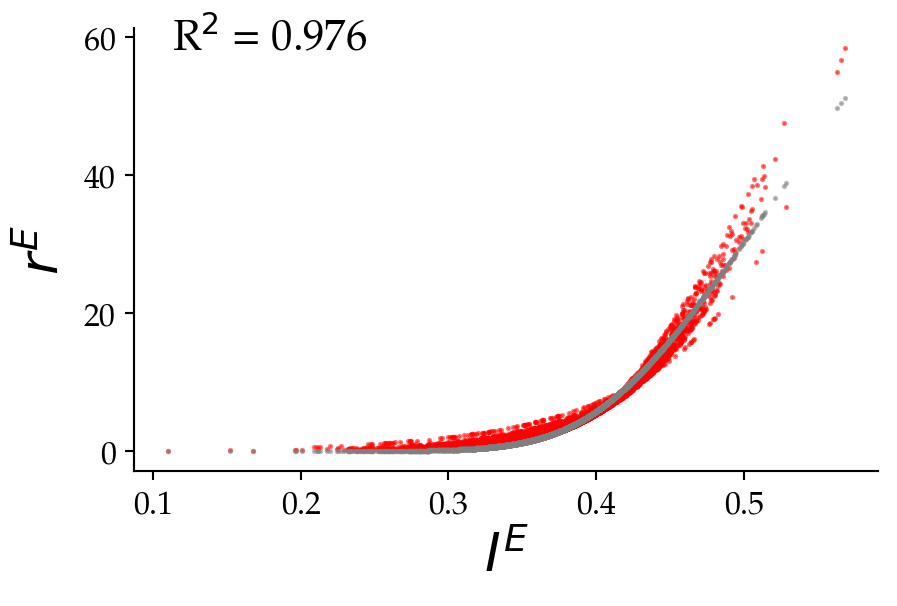

In [64]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(long_df['I_E'], long_df['r_E']-residuals['Log']['r_E~I_E'], s=1, color='red', alpha=0.5)
ax.scatter(long_df['I_E'], long_df['r_E'], s=1, color='grey', alpha=0.5)
ax.set_xlabel(r'$I^E$', fontsize=20)
ax.set_ylabel(r'$r^E$', fontsize=20)
text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
ax.text(text_x, text_y, r'R$^2$ = 'f'{r2s["Log"]["r_E~I_E"]:.3f}', color="black", size=16, multialignment="left")
sns.despine()

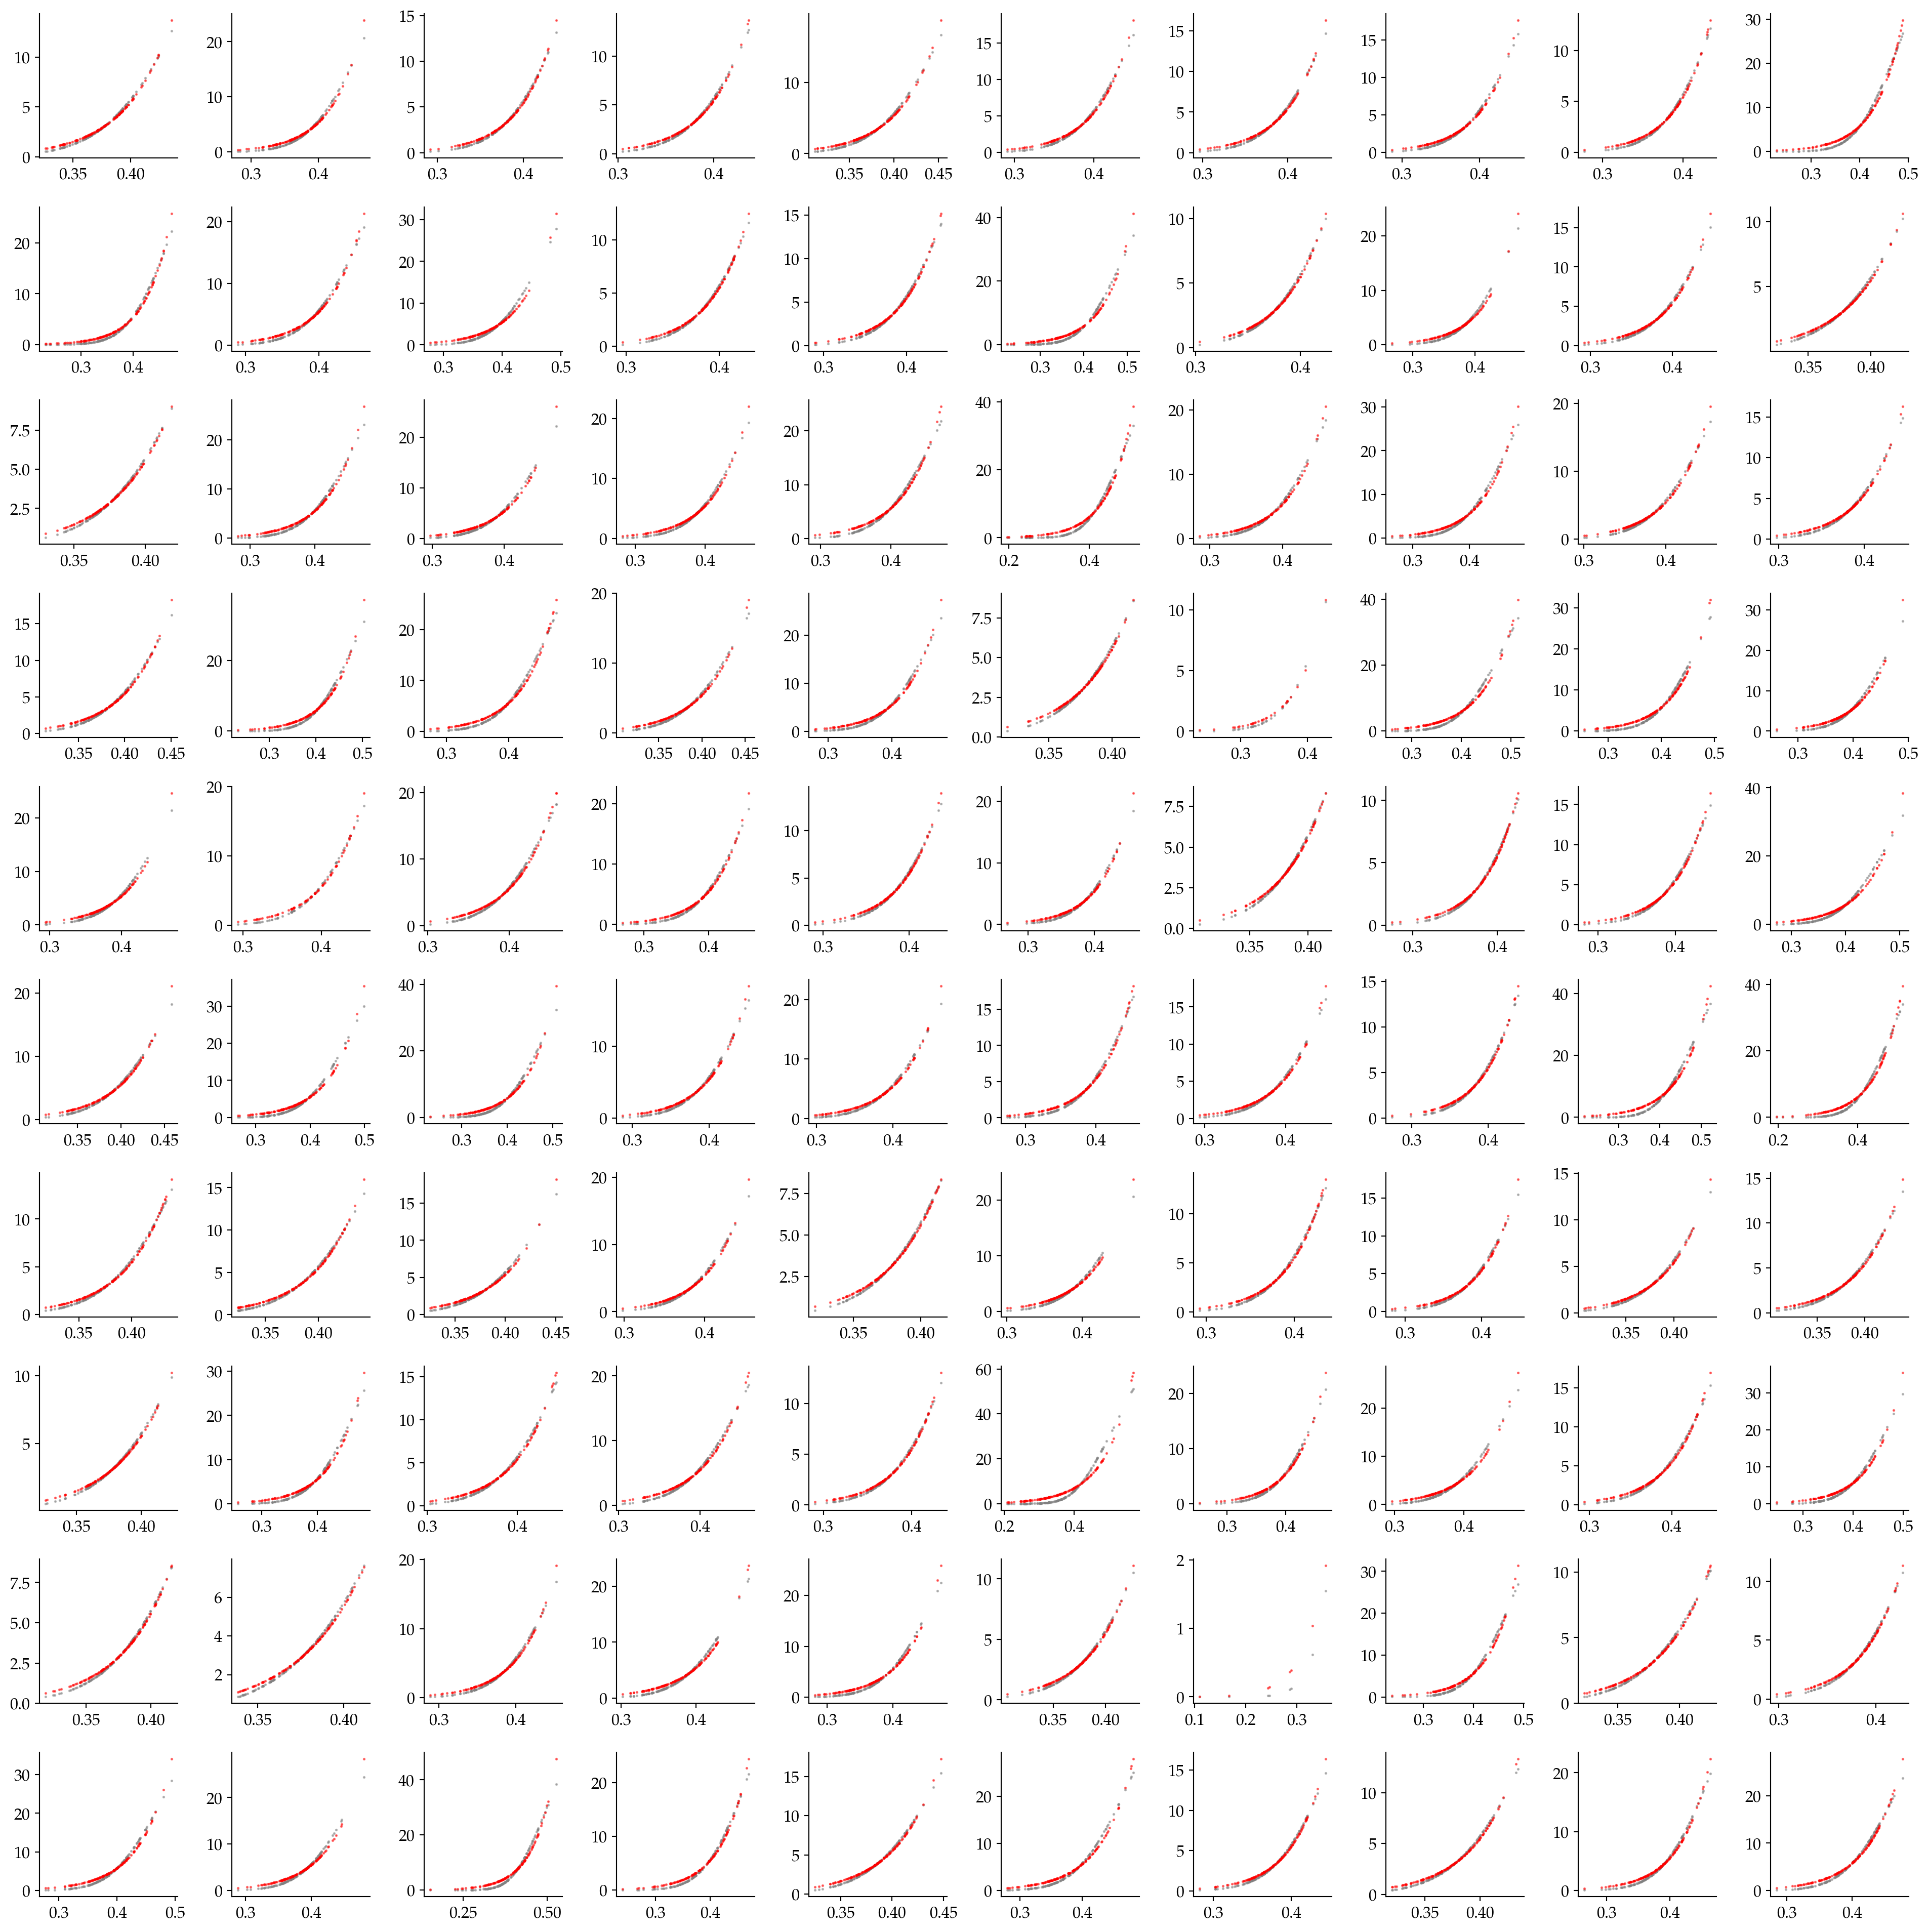

In [84]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.flatten()

for node, node_df in long_df.groupby('node'):
    ax = axes[node]
    ax.scatter(node_df['I_E'], node_df['r_E'], s=1, color='grey', alpha=0.5)
    ax.scatter(node_df['I_E'], node_df['r_E']-residuals['Log']['r_E~I_E'].loc[node_df.index], s=1, color='red', alpha=0.5)
    sns.despine()
fig.tight_layout()

(0.0, 1.0, 0.0, 1.0)

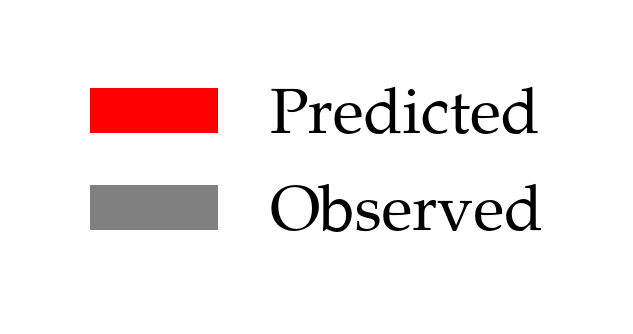

In [234]:
from matplotlib.patches import Patch
colors = {"Predicted": 'red', "Observed": 'grey'}
legend_handles = [
    Patch(facecolor=colors[label], edgecolor="none", label=label) for label in colors
]
plt.figure(figsize=(4, 2))
plt.legend(handles=legend_handles, fontsize="24", loc="center", frameon=False)
plt.axis("off")

#### $r^E$ ~ $\frac{S^E}{S^I}$

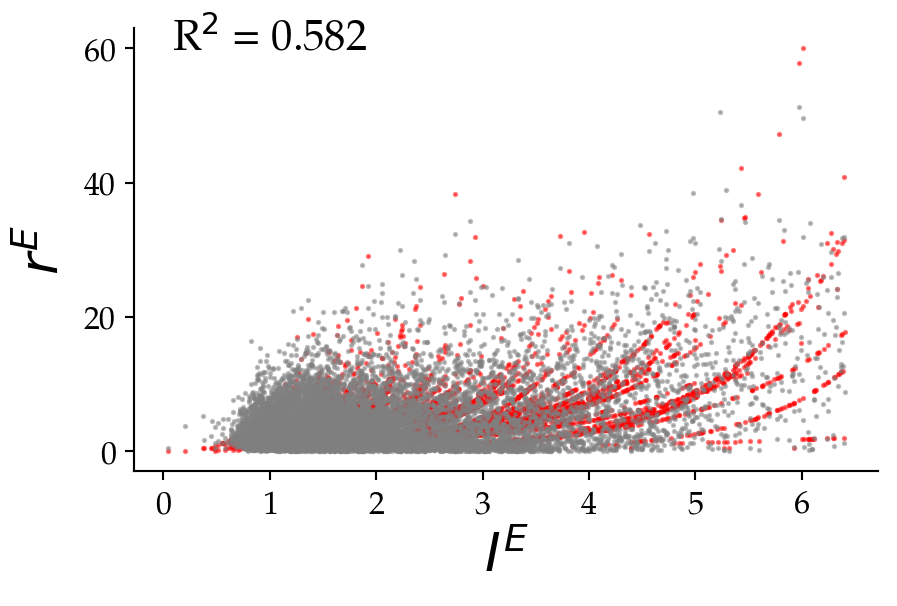

In [65]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(long_df['S_ratio'], long_df['r_E']-residuals['Log']['r_E~S_ratio'], s=1, color='red', alpha=0.5)
ax.scatter(long_df['S_ratio'], long_df['r_E'], s=1, color='grey', alpha=0.5)
ax.set_xlabel(r'$I^E$', fontsize=20)
ax.set_ylabel(r'$r^E$', fontsize=20)
text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
ax.text(text_x, text_y, r'R$^2$ = 'f'{r2s["Log"]["r_E~S_ratio"]:.3f}', color="black", size=16, multialignment="left")
sns.despine()

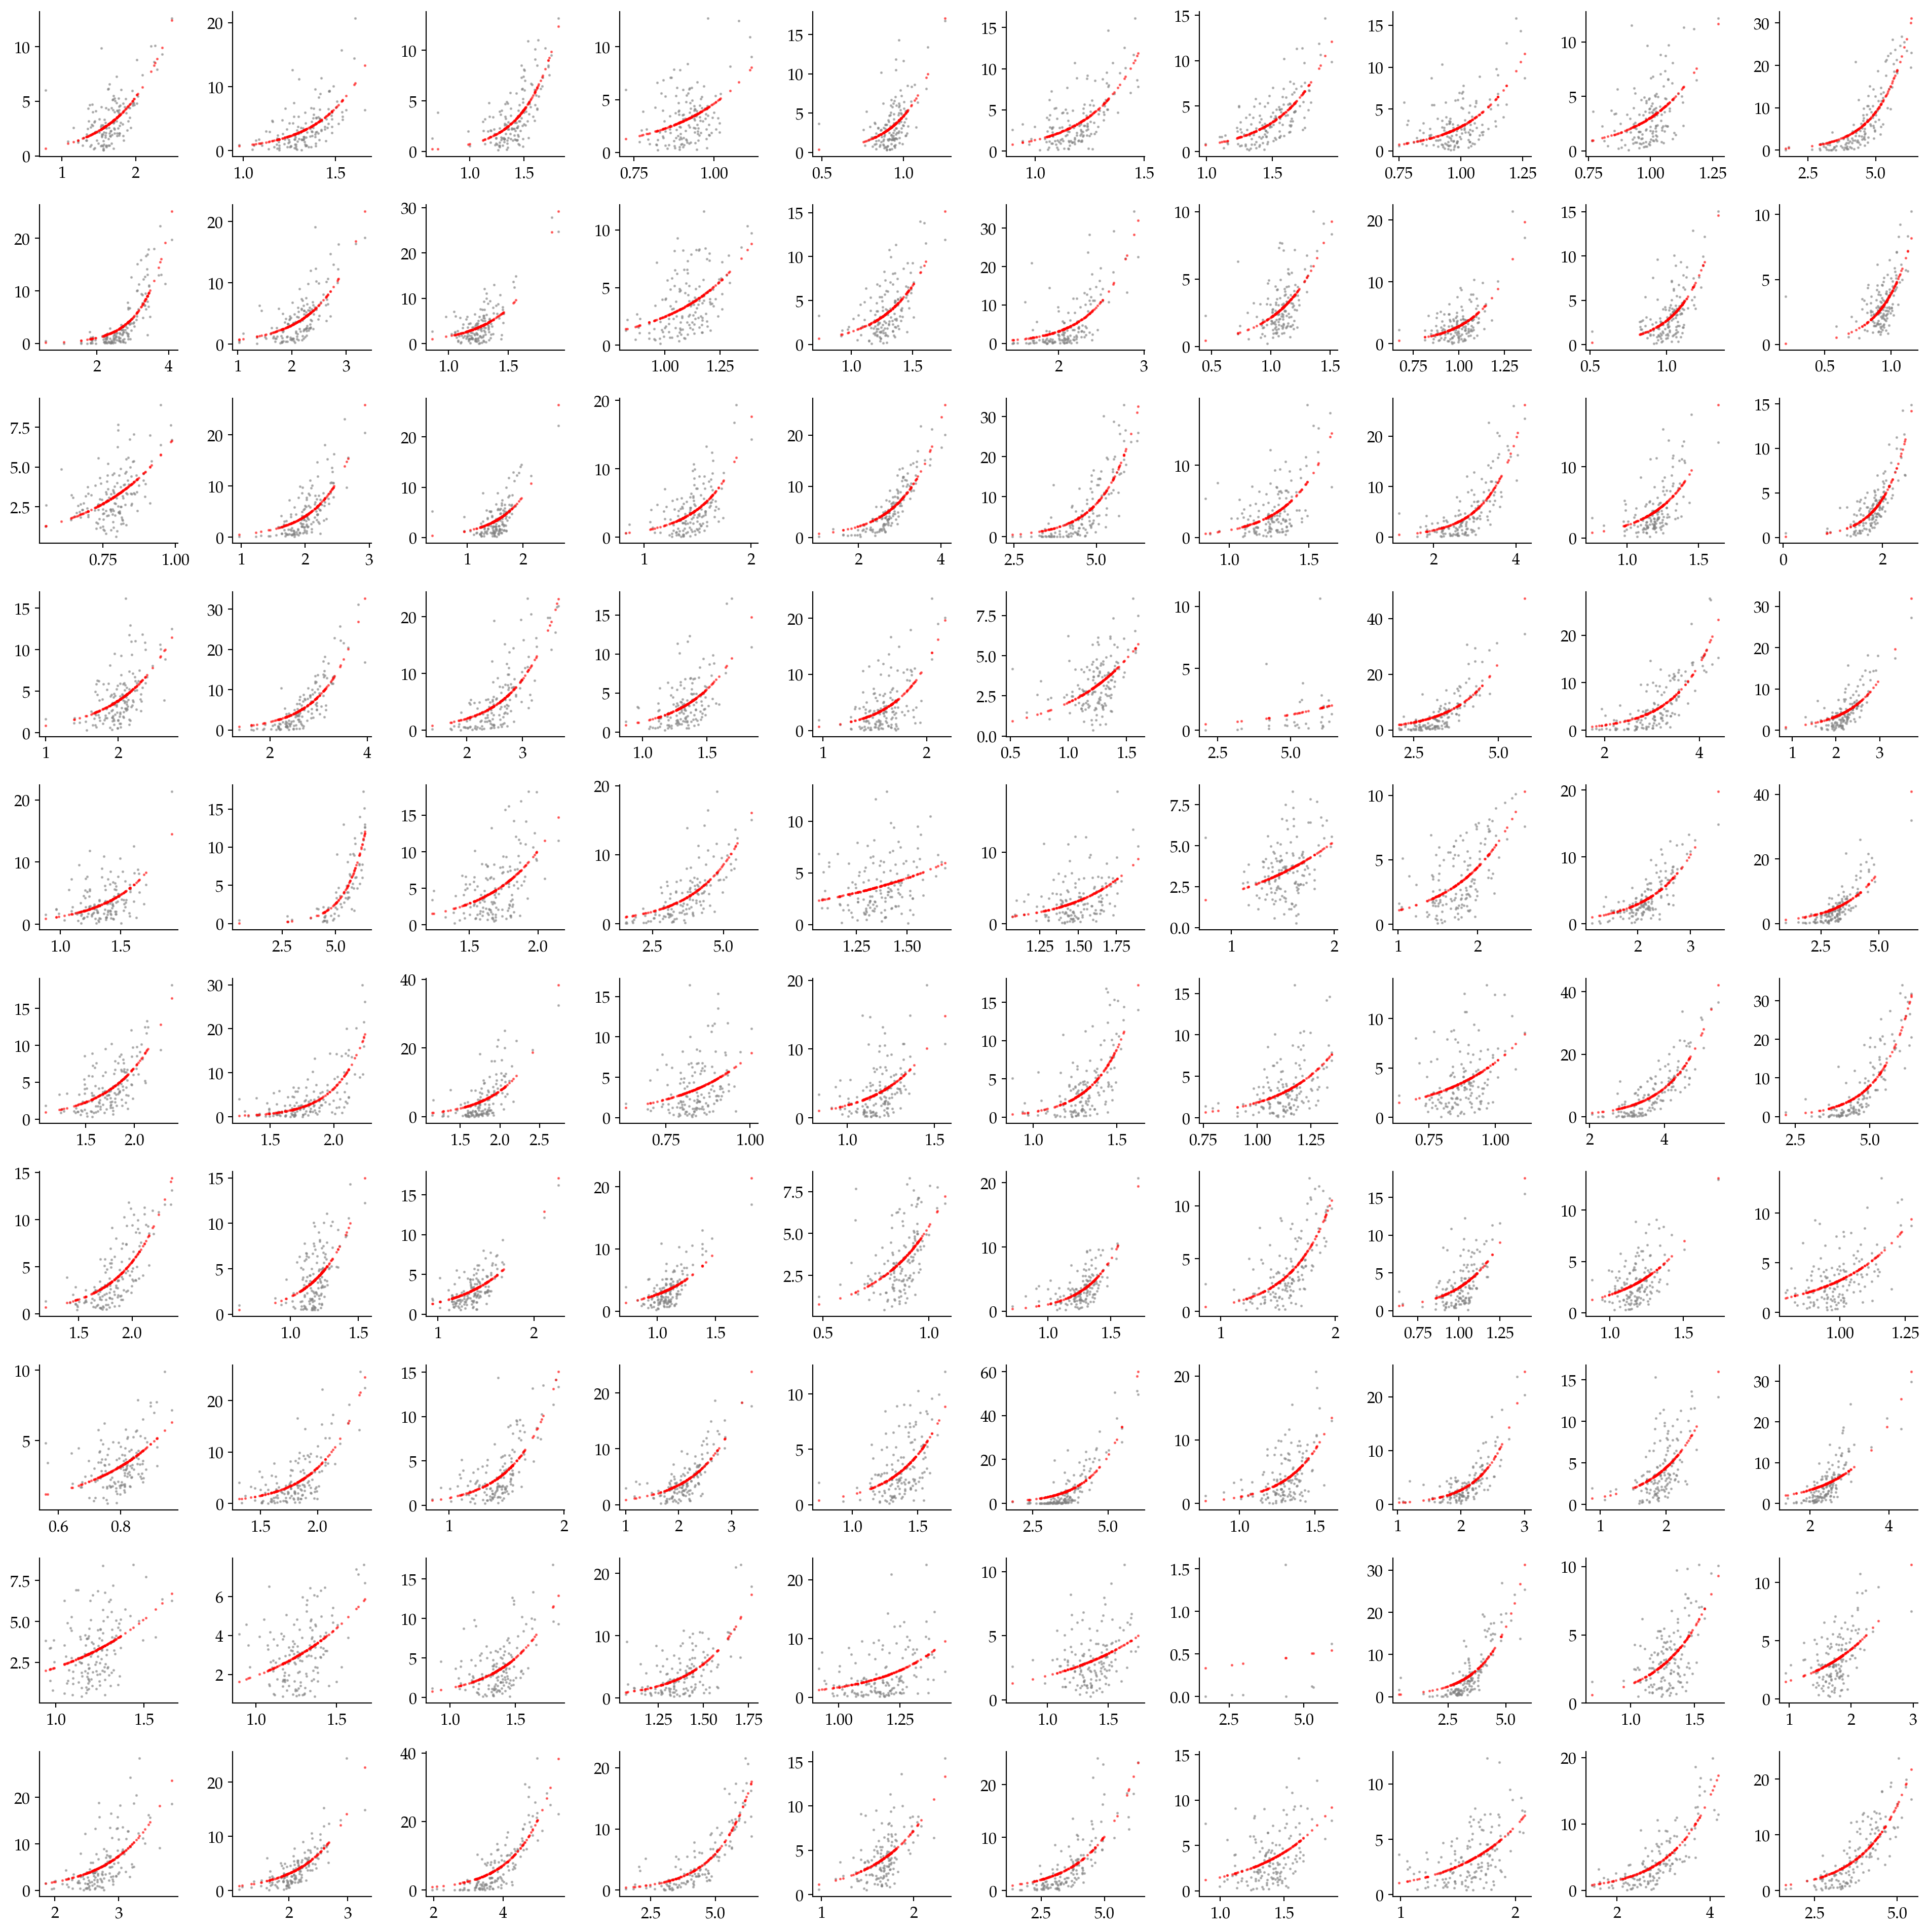

In [86]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.flatten()

for node, node_df in long_df.groupby('node'):
    ax = axes[node]
    ax.scatter(node_df['S_ratio'], node_df['r_E'], s=1, color='grey', alpha=0.5)
    ax.scatter(node_df['S_ratio'], node_df['r_E']-residuals['Log']['r_E~S_ratio'].loc[node_df.index], s=1, color='red', alpha=0.5)
    sns.despine()
fig.tight_layout()

# Figure S17. Effect of model parameters perturbations on $\langle I_i^E \rangle$ and $\frac{\langle S_i^E \rangle}{\langle S_i^I \rangle}$.

First run the perturbed simulations for 40 randomly selected subjects in `scripts/modeling/run/cuBNM/perturbation`.

Load perturbed simulations data:

In [67]:
data40 = data.sample(n=40, random_state=0)

int_data = []
int_raw = {}
for sub in tqdm(data40.index):
    SeedMW = data40.loc[sub, 'SeedMW']
    orig_sim_data = np.load(
        os.path.join(
            os.environ["PNC_PROJECT_DIR"], "output",
            "sim", sub,
            "ctx_parc-schaefer-100_mean001_thresh-1",
            "6maps_schaefer-100_zscore", "cmaes_multimaps_gpu",
            f"ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass-none_exc-inter_G_0.5-4_wee_0.05-0.75_wei_0.05-0.75_wie_0_het-wee-wei_SeedMW-{SeedMW}_SeedSim-410_n-81x210_cuBNM",
            "ts", "it1.npz",
        ),
        allow_pickle=True,
    )
    # in all state average calculations the first 30 seconds (10 TRs) are discarded
    orig_S_ratio = (
        orig_sim_data["sim_states"].reshape(1)[0]["S_E"][0, 10:].mean(axis=0) /
        orig_sim_data["sim_states"].reshape(1)[0]["S_I"][0, 10:].mean(axis=0)
    )
    int_raw[sub] = {}
    int_raw[sub]['orig'] = {
        'S_ratio': orig_S_ratio,
        'I_E': orig_sim_data["sim_states"].reshape(1)[0]["I_E"][0, 10:].mean(axis=0)
    }
    for alt_param in ["wEE", "wEI", "wIE", "G"]:
        int_raw[sub][alt_param] = {}
        for ratio in [0.9, 1.1]:
            curr_data = {
                'sub': sub,
                'alt': alt_param,
                'ratio': ratio,
            }
            int_raw[sub][alt_param][ratio] = {}
            alt_sim_data = np.load(
                os.path.join(
                    os.environ["PNC_PROJECT_DIR"], "output",
                    "sim", sub,
                    "ctx_parc-schaefer-100_mean001_thresh-1",
                    "6maps_schaefer-100_zscore", "cmaes_multimaps_gpu",
                    f"ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass-none_exc-inter_G_0.5-4_wee_0.05-0.75_wei_0.05-0.75_wie_0_het-wee-wei_SeedMW-{SeedMW}_SeedSim-410_n-81x210_cuBNM",
                    f"int-{alt_param}_x{round(ratio, 2)}", "it1.npz",
                ),
                allow_pickle=True,
            )
            alt_S_ratio = (
                alt_sim_data["sim_states"].reshape(1)[0]["S_E"][0, 10:].mean(axis=0) /
                alt_sim_data["sim_states"].reshape(1)[0]["S_I"][0, 10:].mean(axis=0)
            )
            curr_data['S_ratio_T'] = scipy.stats.ttest_rel(
                alt_S_ratio, orig_S_ratio
            ).statistic
            curr_data['I_E_T'] = scipy.stats.ttest_rel(
                alt_sim_data["sim_states"].reshape(1)[0]["I_E"][0, 10:].mean(axis=0),
                orig_sim_data["sim_states"].reshape(1)[0]["I_E"][0, 10:].mean(axis=0)
            ).statistic
            int_data.append(curr_data)
            int_raw[sub][alt_param][ratio]['S_ratio'] = alt_S_ratio
            int_raw[sub][alt_param][ratio]['I_E'] = alt_sim_data["sim_states"].reshape(1)[0]["I_E"][0, 10:].mean(axis=0)
int_data = pd.DataFrame(int_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.64it/s]


## a. Effect of perturbations on optimal simulation of an example subject

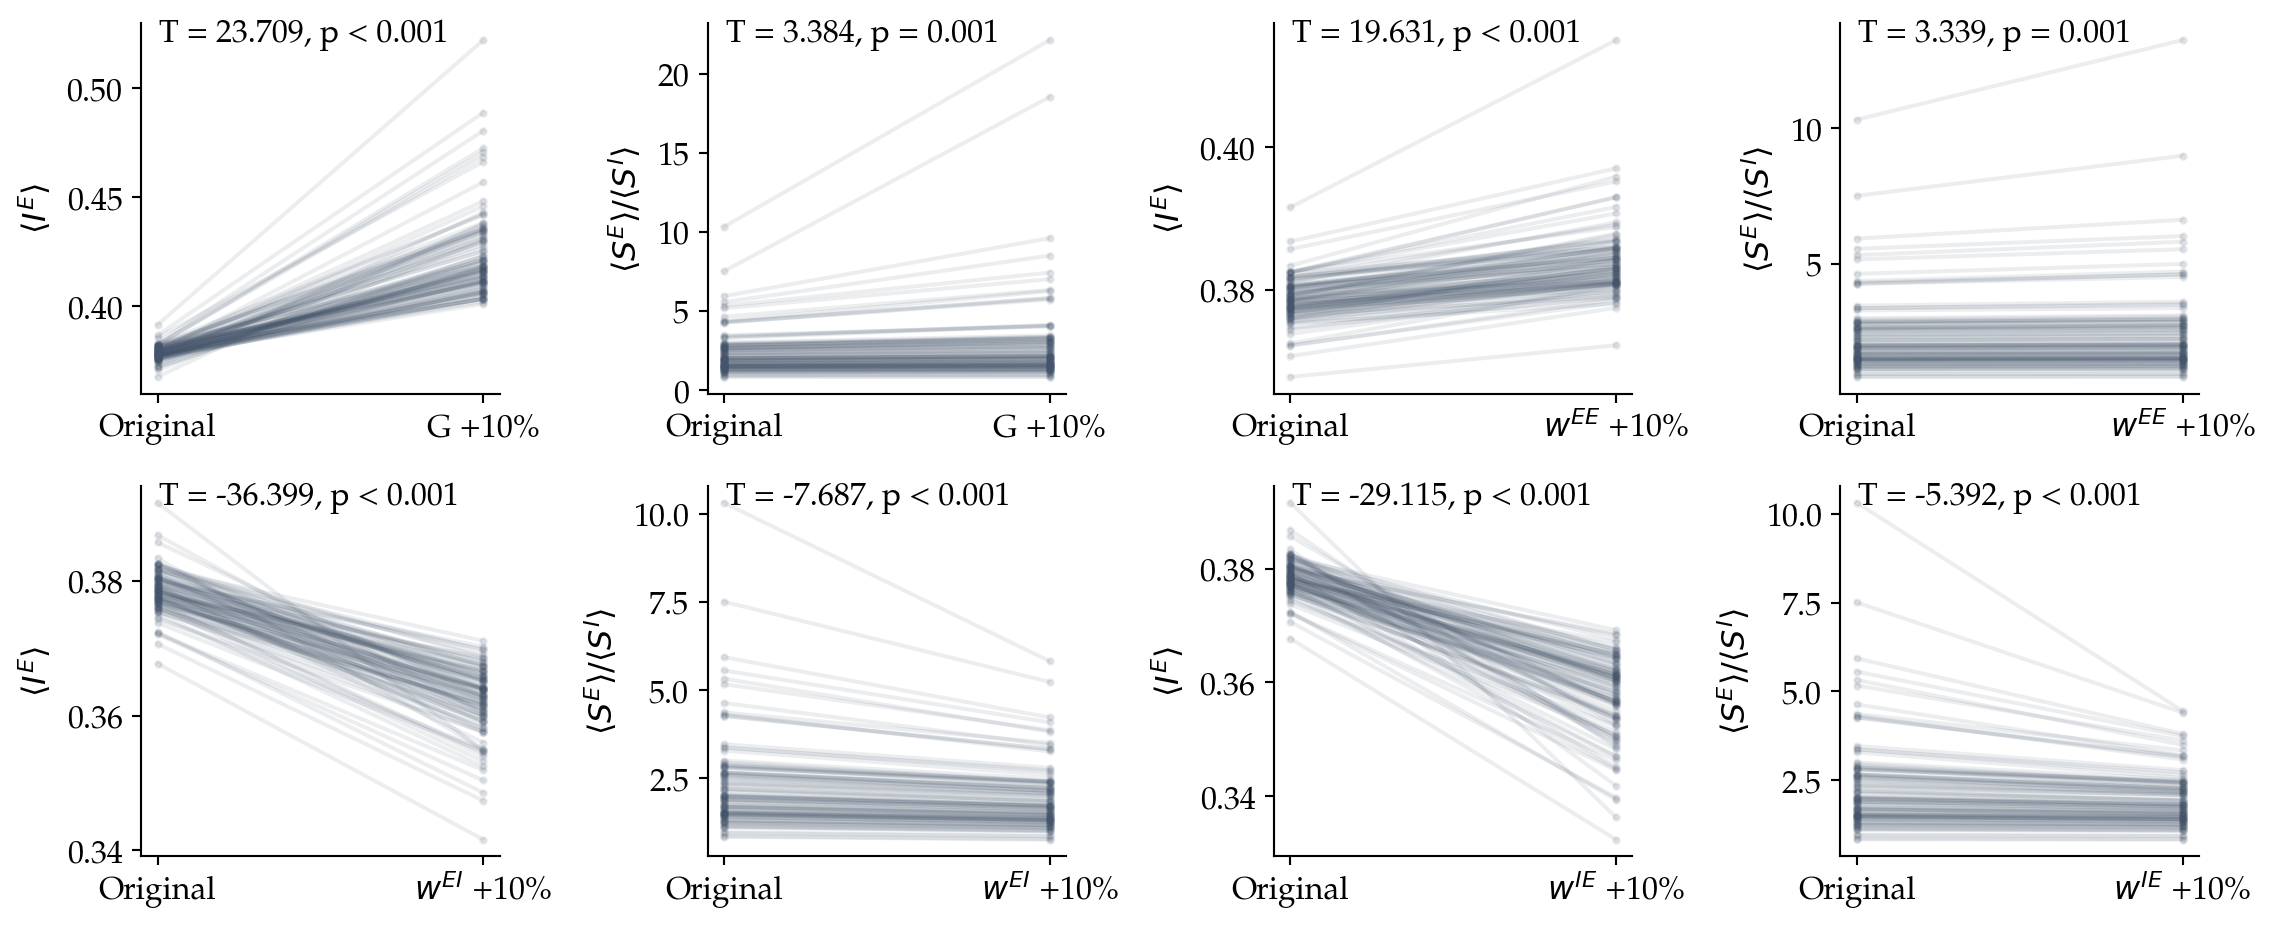

In [68]:
fig, axes = plt.subplots(2, 4, figsize=(12, 5))
axes = axes.flatten()
clean_names = {
    'G': 'G',
    'wEE': r'$w^{EE}$',
    'wEI': r'$w^{EI}$',
    'wIE': r'$w^{IE}$',
    'I_E': r'$\langle I^E \rangle$',
    'S_ratio': r'$\langle S^E \rangle/\langle S^I \rangle$'
}

for i, param in enumerate(['G', 'wEE', 'wEI', 'wIE']):
    for k, measure in enumerate(['I_E', 'S_ratio']):
        ax = axes[i*2+k]
        df = pd.DataFrame({
            'Original': int_raw[sub]['orig'][measure],
            f'{clean_names[param]} +10%': int_raw[sub][param][1.1][measure],
        })
        long_df = df.unstack().reset_index()
        ax.scatter(
            long_df["level_0"], long_df[0], color=thcolor, s=5, alpha=0.1
        )
        for node in range(100):
            node_df = long_df.loc[long_df["level_1"] == node]
            ax.plot(
                node_df["level_0"],
                node_df[0],
                color=thcolor,
                alpha=0.1,
            )
        t = scipy.stats.ttest_rel(df.iloc[:,1], df.iloc[:,0]).statistic
        p = scipy.stats.ttest_rel(df.iloc[:,1], df.iloc[:,0]).pvalue
        text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
        text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
        text = f'T = {t:.3f}, '
        if p < 0.001:
            text+= 'p < 0.001'
        else:
            text+= f'p = {p:.3f}'
        ax.text(text_x, text_y, text, color="black", multialignment="left")
        ax.set_ylabel(clean_names[measure])
        sns.despine()
fig.tight_layout()

## b. Distribution of perturbtaion effect paired T statistics across all 40 subjects

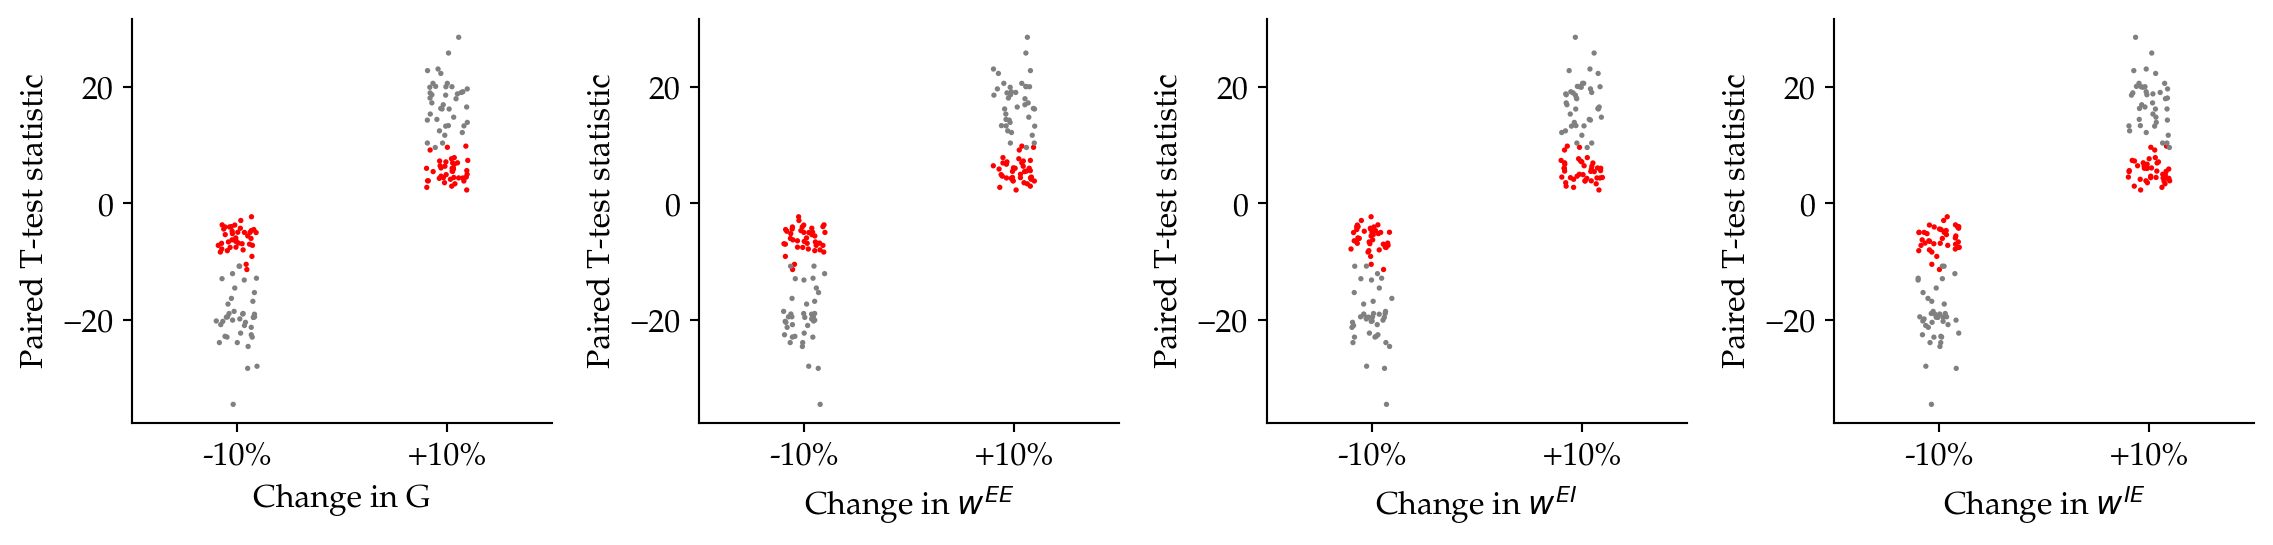

In [69]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes = axes.flatten()
for i, param in enumerate(['G', 'wEE', 'wEI', 'wIE']):
    ax = axes[i]
    curr_data = int_data.loc[(int_data['alt']=='wEE') & (int_data['ratio'].isin([0.9, 1.1]))]
    sns.stripplot(data=curr_data, y='S_ratio_T', x='ratio', ax=ax, color='red', size=2)
    sns.stripplot(data=curr_data, y='I_E_T', x='ratio', ax=ax, color='grey', size=2)
    ax.set_xlabel(f'Change in {clean_names[param]}')
    ax.set_xticklabels(['-10%', '+10%'])
    ax.set_ylabel('Paired T-test statistic')
    sns.despine()
fig.tight_layout()

(0.0, 1.0, 0.0, 1.0)

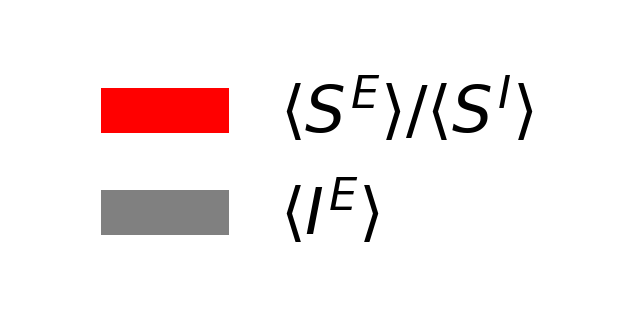

In [70]:
from matplotlib.patches import Patch
colors = {clean_names['S_ratio']: 'red', clean_names['I_E']: 'grey'}
legend_handles = [
    Patch(facecolor=colors[label], edgecolor="none", label=label) for label in colors
]
plt.figure(figsize=(4, 2))
plt.legend(handles=legend_handles, fontsize="24", loc="center", frameon=False)
plt.axis("off")

# Figure S18. Effect of age on $\frac{\langle S_i^E \rangle}{\langle S_i^I \rangle}$ and its robustness across different configurations in the PNC dataset.

## a. Subject-level with default configurations

Calculate age effects:

In [98]:
S_ratio = pd.DataFrame(index=data.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for sub, row in data.iterrows():
        S_ratio.loc[sub, parc] = regional_vars[sub][row["SeedMW"]].loc[i, "S_E"] / regional_vars[sub][row["SeedMW"]].loc[i, "S_I"]

In [101]:
df = pd.concat([S_ratio, data], axis=1)
df.columns = [f"node_{i}" for i in range(100)] + list(df.columns[100:])

t_age = pd.Series(index=parcels)
r_age = pd.Series(index=parcels)
p_age = pd.Series(index=parcels)
for i, parc in enumerate(parcels):
    # exclude outliers
    curr_subs = S_ratio.index[(scipy.stats.zscore(S_ratio.loc[:, parc]).abs() < 3)]
    model_df = df.loc[curr_subs]
    # fit the confound removal model to calculate pearson's r of the
    # residual of I_E with age as an easy-to-interpret effect size
    res_conf = smf.ols(f"node_{i} ~ gof + sex + mean_rms", data=model_df).fit()
    r_age.loc[parc] = scipy.stats.pearsonr(model_df["age"], res_conf.resid).statistic
    # fit the main model
    mod = smf.ols(f"node_{i} ~ age + gof + sex + mean_rms", data=model_df)
    res = mod.fit()
    t_age.loc[parc] = res.tvalues["age"]
    p_age.loc[parc] = res.pvalues["age"]

# FDR correction
_, p_age_fdr = statsmodels.stats.multitest.fdrcorrection(p_age)
p_age_fdr = pd.Series(p_age_fdr, index=parcels)

# display stats of signficant regions
stats_age = pd.DataFrame({"t": t_age, "r": r_age, "p": p_age, "p_fdr": p_age_fdr})
stats_age.to_csv("p_pnc_fc-sub_sc-sub_runs-2_Sratio_age_stats.csv")
stats_age[stats_age["p_fdr"] < 0.05].sort_values(by="t").round(3)

t      r      p  p_fdr
7Networks_RH_Cont_PFCl_3      2.105  0.076  0.036  0.050
7Networks_RH_Default_Temp_1   2.147  0.077  0.032  0.045
7Networks_RH_Cont_PFCmp_1     2.194  0.079  0.029  0.041
7Networks_LH_Cont_PFCl_1      2.265  0.081  0.024  0.035
7Networks_LH_DorsAttn_Post_5  2.617  0.094  0.009  0.013
...                             ...    ...    ...    ...
7Networks_RH_Vis_1            6.536  0.229  0.000  0.000
7Networks_LH_Vis_7            6.586  0.231  0.000  0.000
7Networks_LH_DorsAttn_FEF_1   7.069  0.246  0.000  0.000
7Networks_RH_Vis_3            7.138  0.248  0.000  0.000
7Networks_RH_Vis_7            7.518  0.260  0.000  0.000

[72 rows x 4 columns]

Plot unthresholded effects:

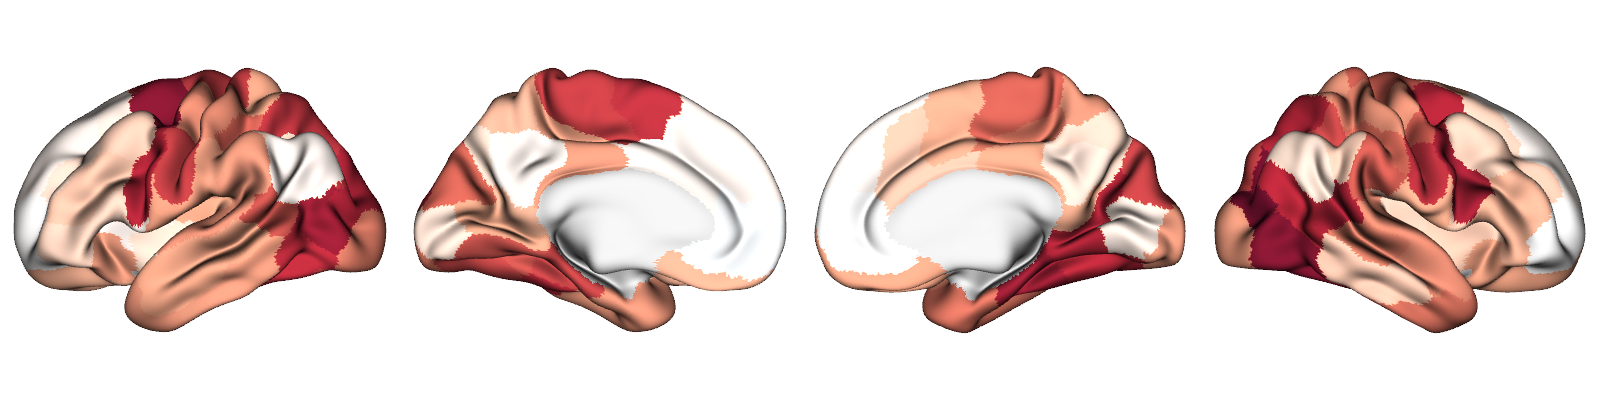

In [103]:
plot.plot_surface(
    transform.deparcellate_surf(t_age, "schaefer-100", concat=True, space="fsaverage"),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange="sym",
    cmap="RdBu_r",
    cbar=False,
    layout_style="row",
)

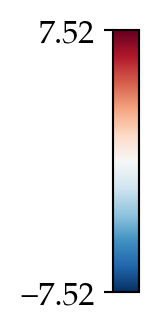

In [104]:
vmin = min(t_age.values.min(), -t_age.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), "RdBu_r", figsize=(2, 2));

## b. Age-group-level using template SC

Load data:

In [106]:
groups = pd.read_csv(
    os.path.join(os.environ['INPUT_DIR'], "pnc_age_groups.csv"), index_col=0
).sort_index()

if os.path.exists('pnc_fc-group_sc-micamics_runs-1.csv') & os.path.exists('pnc_fc-group_sc-micamics_runs-1_vars.pkz'):
    groups_optima = pd.read_csv('pnc_fc-group_sc-micamics_runs-1.csv', index_col=0)
    with open('pnc_fc-group_sc-micamics_runs-1_vars.pkz', 'rb') as f:
        regional_vars_group = pickle.load(f)
else:
    print("Run Figure 5 first")

data_group = groups_optima.set_index('group')
data_group[['Age (y)', 'Fp']] = groups.loc[data_group.index,['age', 'F%']]

# add group-averaged motion data
motion = pd.read_csv(
    os.path.join(OUTPUT_DIR["pnc"], 'postfmriprep', 'participants.tsv'), 
    delimiter="\t", index_col=0
)
group_motion = pd.DataFrame(index=groups.index, columns=motion.columns, dtype=float)
for group in groups.index:
    group_subs = np.loadtxt(
        os.path.join(
            OUTPUT_DIR['pnc'], 'FC',
            group, 'subjects.txt'
        ), dtype=str
    )
    group_motion.loc[group, :] = motion.loc[group_subs].median(axis=0)
data_group = pd.concat([data_group, group_motion], axis=1)

In [107]:
S_ratio_group = pd.DataFrame(index=data_group.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for group, row in data_group.iterrows():
        S_ratio_group.loc[group, parc] = regional_vars_group[group][row['SeedMW']].loc[i, 'S_E'] / regional_vars_group[group][row['SeedMW']].loc[i, 'S_I']

Calculate age effects:

In [108]:
df = pd.concat([S_ratio_group, data_group], axis=1)
df.columns = [f'node_{i}' for i in range(100)] + list(df.columns[100:])
df['age'] = df['Age (y)']

t_age_group = pd.Series(index=parcels)
p_age_group = pd.Series(index=parcels)
outliers = {}
for i, parc in enumerate(parcels):
    # fit the model
    mod = smf.ols(f'node_{i} ~ age + gof + Fp + mean_rms', data=df)
    res = mod.fit()
    t_age_group.loc[parc] = res.tvalues['age']
    p_age_group.loc[parc] = res.pvalues['age']

# FDR correction
_, p_age_group_fdr = statsmodels.stats.multitest.fdrcorrection(p_age_group)
p_age_group_fdr = pd.Series(p_age_group_fdr, index=parcels)

# display stats of signficant regions
stats_age_group = pd.DataFrame({"t": t_age_group, "p": p_age_group, "p_fdr": p_age_group_fdr})
stats_age_group.to_csv("p_pnc_fc-group_sc-micamics_runs-1_Sratio_age_stats.csv")
stats_age_group[stats_age_group["p_fdr"] < 0.05].sort_values(by="t").round(3)

t      p  p_fdr
7Networks_LH_Default_PFC_5      -4.855  0.000  0.003
7Networks_RH_Default_PFCdPFCm_2 -4.788  0.000  0.003
7Networks_RH_Cont_Par_2         -4.555  0.000  0.003
7Networks_LH_Default_PFC_6      -4.378  0.000  0.003
7Networks_RH_Limbic_OFC_1       -4.317  0.000  0.003
7Networks_RH_Default_PFCv_2     -4.292  0.000  0.003
7Networks_RH_Cont_PFCl_4        -4.277  0.000  0.003
7Networks_RH_Cont_Par_1         -4.224  0.000  0.003
7Networks_RH_Default_Temp_1     -4.218  0.000  0.003
7Networks_LH_Default_PFC_2      -4.185  0.000  0.003
7Networks_LH_Limbic_OFC_1       -4.101  0.000  0.003
7Networks_RH_Default_PFCdPFCm_3 -4.016  0.000  0.004
7Networks_LH_Default_Temp_1     -3.973  0.001  0.004
7Networks_LH_Limbic_TempPole_2  -3.942  0.001  0.004
7Networks_RH_Limbic_TempPole_1  -3.531  0.002  0.010
7Networks_LH_Cont_Par_1         -3.509  0.002  0.010
7Networks_LH_Limbic_TempPole_1  -3.444  0.002  0.010
7Networks_RH_Default_PFCv_1     -3.428  0.002  0.010
7Networks_RH_Default_Par_1      -3.384  0.002  0.010
7Networks_LH_Default_Temp_2     -3.356  0.003  0.010
7Networks_LH_Default_PFC_7      -3.349  0.003  0.010
7Networks_LH_Default_Par_2      -3.191  0.004  0.015
7Networks_LH_Cont_pCun_1        -3.120  0.005  0.016
7Networks_RH_Cont_pCun_1        -3.008  0.006  0.020
7Networks_LH_Vis_1              -2.931  0.007  0.022
7Networks_LH_Default_PFC_1      -2.893  0.008  0.022
7Networks_RH_Cont_PFCl_1        -2.665  0.013  0.037
7Networks_RH_Cont_PFCl_2        -2.615  0.015  0.040
7Networks_RH_Default_pCunPCC_2  -2.596  0.016  0.040
7Networks_LH_Default_pCunPCC_1  -2.571  0.016  0.041
7Networks_RH_Vis_2               2.456  0.021  0.050
7Networks_LH_SomMot_2            2.483  0.020  0.048
7Networks_LH_SomMot_6            2.520  0.018  0.045
7Networks_LH_SomMot_1            2.598  0.015  0.040
7Networks_RH_SomMot_1            2.891  0.008  0.022
7Networks_RH_SomMot_4            2.906  0.008  0.022
7Networks_RH_Vis_3               2.969  0.007  0.021
7Networks_RH_Vis_8               3.050  0.005  0.018
7Networks_LH_SomMot_5            3.163  0.004  0.015
7Networks_LH_Vis_7               3.363  0.002  0.010
7Networks_LH_Vis_8               3.410  0.002  0.010
7Networks_LH_SomMot_4            3.468  0.002  0.010
7Networks_RH_Vis_7               3.494  0.002  0.010

Plot unthresholded:

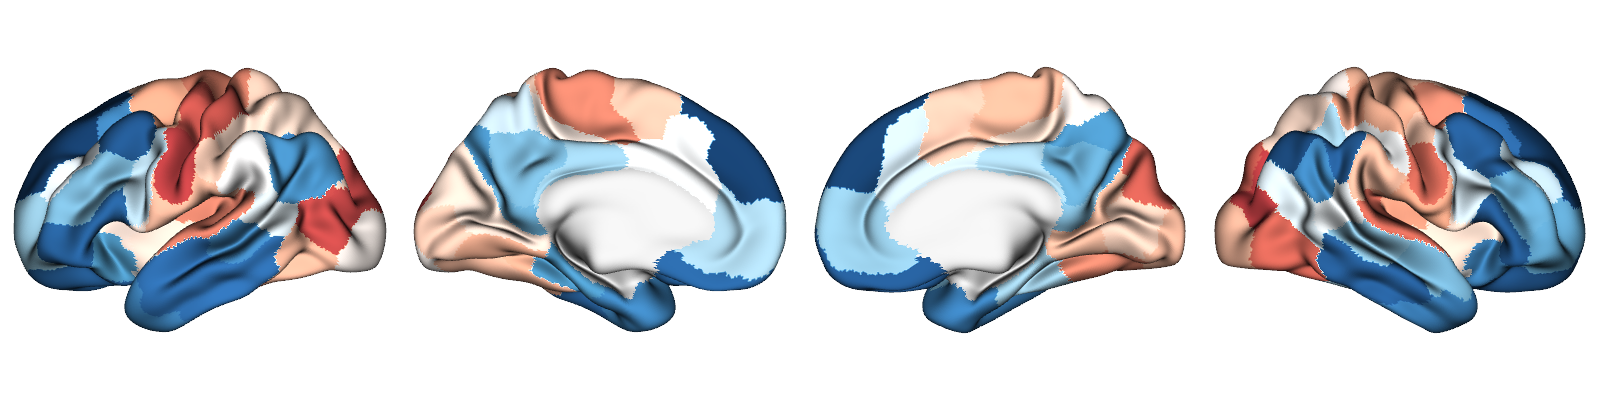

In [111]:
plot.plot_surface(
    transform.deparcellate_surf(t_age_group, 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange='sym', cmap='RdBu_r', cbar=False,
    layout_style='row',
)

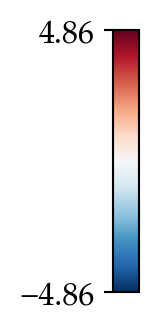

In [116]:
vmin = min(t_age_group.values.min(), -t_age_group.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), "RdBu_r", figsize=(2, 2));

## c-left. Controlled for SC strength (subject-level)

Calculate SC strength:

In [112]:
sc_strength = pd.DataFrame(index=data.index, columns=parcels, dtype=float)
for sub in tqdm(data.index):
    sc = pd.read_csv(
        os.path.join(OUTPUT_DIR['pnc'], 'SC', sub, 
                     'ctx_parc-schaefer-100_mean001_thresh-1_desc-strength.csv.gz'),
        index_col=0)
    sc_strength.loc[sub, :] = sc.sum(axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 752/752 [00:03<00:00, 216.46it/s]


Calculate age effects while controlling for SC strength:

In [113]:
df = pd.concat([S_ratio, sc_strength, data], axis=1)
df.columns = [f'Sratio_{i}' for i in range(100)] + [f'SC_{i}' for i in range(100)] + list(df.columns[200:])
df['sex_int'] = (df['sex'] == 'F').astype('int')

t_age_sc_conf = pd.Series(index=parcels)
p_age_sc_conf = pd.Series(index=parcels)
outliers = {}
for i, parc in enumerate(parcels):
    # exclude outliers
    curr_subs = S_ratio.index[(scipy.stats.zscore(S_ratio.loc[:, parc]).abs() < 3)]
    outliers[parc] = set(df.index) - set(curr_subs)
    model_df = df.loc[curr_subs]
    # fit the model
    mod = smf.ols(f'Sratio_{i} ~ age + gof + sex_int + mean_rms + SC_{i}', data=model_df)
    res = mod.fit()
    t_age_sc_conf.loc[parc] = res.tvalues['age']
    p_age_sc_conf.loc[parc] = res.pvalues['age']

# FDR correction
_, p_age_sc_conf_fdr = statsmodels.stats.multitest.fdrcorrection(p_age_sc_conf)
p_age_sc_conf_fdr = pd.Series(p_age_sc_conf_fdr, index=parcels)

# display stats of signficant regions
stats_age_sc_conf = pd.DataFrame({"t": t_age_sc_conf, "p": p_age_sc_conf, "p_fdr": p_age_sc_conf_fdr})
stats_age_sc_conf.to_csv("p_pnc_fc-sub_sc-sub_runs-2_Sratio_age_sc_conf_stats.csv")
stats_age_sc_conf[stats_age_sc_conf["p_fdr"] < 0.05].sort_values(by="t").round(3)

t      p  p_fdr
7Networks_RH_Default_Temp_1   2.214  0.027  0.039
7Networks_RH_Cont_PFCmp_1     2.255  0.024  0.035
7Networks_LH_DorsAttn_Post_5  2.321  0.021  0.030
7Networks_RH_Default_PFCv_2   2.549  0.011  0.016
7Networks_RH_Cont_PFCl_2      2.550  0.011  0.016
...                             ...    ...    ...
7Networks_LH_Vis_7            6.486  0.000  0.000
7Networks_RH_Vis_1            6.522  0.000  0.000
7Networks_LH_DorsAttn_FEF_1   7.062  0.000  0.000
7Networks_RH_Vis_3            7.101  0.000  0.000
7Networks_RH_Vis_7            7.500  0.000  0.000

[70 rows x 3 columns]

Plot unthresholded:

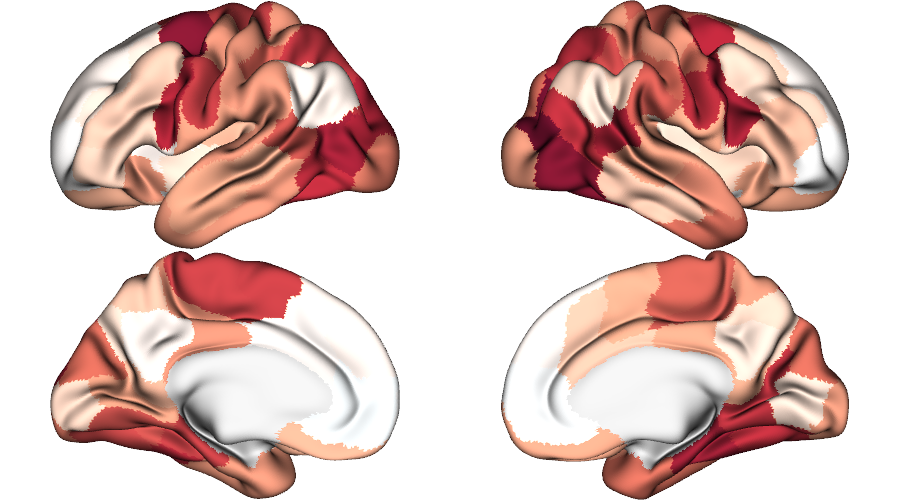

In [115]:
plot.plot_surface(
    transform.deparcellate_surf(t_age_sc_conf, 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange='sym', cmap='RdBu_r', cbar=False,
    layout_style='grid',
)

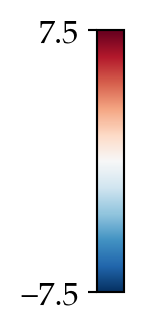

In [117]:
vmin = min(t_age_sc_conf.values.min(), -t_age_sc_conf.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), "RdBu_r", figsize=(2, 2));

Spatial correlation with default age effects:

In [127]:
r_aget_sc_conf, p_aget_sc_conf, _ = stats.spin_test_parcellated(t_age_sc_conf.to_frame(), t_age.to_frame(), 'schaefer-100', n_perm=1000)
print(
    'Correlation coefficients\n',
    r_aget_sc_conf,
    '\nSpin p-values\n',
    p_aget_sc_conf
)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficients
           0
0  0.993537 
Spin p-values
      0
0  0.0


## c-right. Template SC (subject-level)

Load data:

In [118]:
if os.path.exists('pnc_fc-sub_sc-micamics_runs-1.csv') & os.path.exists('pnc_fc-sub_sc-micamics_runs-1_vars.pkz'):
    subjects_optima_temp = pd.read_csv('pnc_fc-sub_sc-micamics_runs-1.csv', index_col=0)
    with open('pnc_fc-sub_sc-micamics_runs-1_vars.pkz', 'rb') as f:
        regional_vars_temp = pickle.load(f)
else:
    print("Run Figure 5 first")

best_runs = subjects_optima_temp.groupby('sub')['gof'].idxmax().values
data_temp = subjects_optima_temp.loc[best_runs].set_index('sub')
data_temp[['age', 'sex','group']] = elig_subs.loc[data_temp.index,['age', 'sex','group']]
data_temp['Age (y)'] = data_temp['age'] / 12
data_temp.head()

# add motion data
motion = pd.read_csv(
    os.path.join(OUTPUT_DIR["pnc"], 'postfmriprep', 'participants.tsv'), 
    delimiter="\t", index_col=0
).loc[data_temp.index]
data_temp = pd.concat([data_temp, motion], axis=1)

In [119]:
S_ratio_temp = pd.DataFrame(index=data_temp.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for sub, row in data_temp.iterrows():
        S_ratio_temp.loc[sub, parc] = regional_vars_temp[sub][row['SeedMW']].loc[i, 'S_E'] / regional_vars_temp[sub][row['SeedMW']].loc[i, 'S_I']

Effect of age:

In [120]:
df = pd.concat([S_ratio_temp, data_temp], axis=1)
df.columns = [f'node_{i}' for i in range(100)] + list(df.columns[100:])
df['age'] = df['Age (y)']

t_age_temp = pd.Series(index=parcels)
p_age_temp = pd.Series(index=parcels)
outliers = {}
for i, parc in enumerate(parcels):
    # exclude outliers
    curr_subs = df.index[(scipy.stats.zscore(df.loc[:, f'node_{i}']).abs() < 3)]
    outliers[parc] = set(df.index) - set(curr_subs)
    model_df = df.loc[curr_subs]
    # fit the model
    mod = smf.ols(f'node_{i} ~ age + gof + sex + mean_rms', data=df)
    res = mod.fit()
    t_age_temp.loc[parc] = res.tvalues['age']
    p_age_temp.loc[parc] = res.pvalues['age']

# FDR correction
_, p_age_temp_fdr = statsmodels.stats.multitest.fdrcorrection(p_age_temp)
p_age_temp_fdr = pd.Series(p_age_temp_fdr, index=parcels)

# display stats of signficant regions
stats_age_temp = pd.DataFrame({"t": t_age_temp, "p": p_age_temp, "p_fdr": p_age_temp_fdr})
stats_age_temp.to_csv("p_pnc_fc-sub_sc-micamics_runs-1_Sratio_age_stats.csv")
stats_age_temp[stats_age_temp["p_fdr"] < 0.05].sort_values(by="t").round(3)

t      p  p_fdr
7Networks_LH_Default_Par_2            -3.925  0.000  0.001
7Networks_RH_Default_Par_1            -3.729  0.000  0.001
7Networks_RH_Cont_PFCl_1              -3.559  0.000  0.001
7Networks_RH_Default_PFCdPFCm_2       -3.528  0.000  0.002
7Networks_LH_Default_PFC_7            -3.446  0.001  0.002
7Networks_LH_Default_PFC_5            -3.422  0.001  0.002
7Networks_RH_Cont_Par_2               -3.389  0.001  0.002
7Networks_RH_Cont_PFCl_4              -3.377  0.001  0.002
7Networks_LH_Default_PFC_6            -3.358  0.001  0.002
7Networks_LH_Default_PFC_2            -3.354  0.001  0.002
7Networks_RH_Default_PFCdPFCm_3       -3.272  0.001  0.003
7Networks_LH_Default_PFC_4            -3.208  0.001  0.003
7Networks_RH_Cont_Par_1               -2.715  0.007  0.013
7Networks_LH_Cont_Par_1               -2.715  0.007  0.013
7Networks_RH_Default_PFCv_2           -2.667  0.008  0.015
7Networks_LH_Cont_PFCl_1              -2.589  0.010  0.019
7Networks_RH_Default_Temp_1           -2.578  0.010  0.019
7Networks_RH_Default_PFCdPFCm_1       -2.266  0.024  0.041
7Networks_LH_Vis_2                     2.217  0.027  0.046
7Networks_RH_SalVentAttn_FrOperIns_1   2.294  0.022  0.039
7Networks_RH_DorsAttn_Post_1           2.389  0.017  0.031
7Networks_LH_DorsAttn_Post_6           2.546  0.011  0.020
7Networks_RH_SalVentAttn_TempOccPar_1  2.761  0.006  0.012
7Networks_LH_SalVentAttn_Med_2         2.837  0.005  0.010
7Networks_RH_Vis_8                     2.873  0.004  0.009
7Networks_RH_SomMot_7                  2.893  0.004  0.009
7Networks_RH_SomMot_6                  2.934  0.003  0.008
7Networks_RH_DorsAttn_Post_2           2.942  0.003  0.008
7Networks_RH_Vis_6                     2.949  0.003  0.008
7Networks_RH_Vis_1                     3.072  0.002  0.005
7Networks_LH_SalVentAttn_FrOperIns_1   3.159  0.002  0.004
7Networks_LH_DorsAttn_Post_3           3.207  0.001  0.003
7Networks_RH_Vis_2                     3.303  0.001  0.003
7Networks_LH_DorsAttn_Post_4           3.461  0.001  0.002
7Networks_RH_SalVentAttn_TempOccPar_2  3.526  0.000  0.002
7Networks_LH_DorsAttn_Post_2           3.558  0.000  0.001
7Networks_LH_SomMot_3                  3.568  0.000  0.001
7Networks_RH_DorsAttn_Post_4           3.586  0.000  0.001
7Networks_LH_DorsAttn_Post_1           3.665  0.000  0.001
7Networks_RH_SomMot_5                  3.729  0.000  0.001
7Networks_RH_SalVentAttn_Med_1         3.843  0.000  0.001
7Networks_LH_SomMot_5                  3.872  0.000  0.001
7Networks_RH_SomMot_2                  4.072  0.000  0.000
7Networks_LH_Vis_8                     4.092  0.000  0.000
7Networks_RH_SalVentAttn_Med_2         4.281  0.000  0.000
7Networks_RH_SomMot_8                  4.309  0.000  0.000
7Networks_RH_SomMot_3                  4.408  0.000  0.000
7Networks_LH_SomMot_1                  4.485  0.000  0.000
7Networks_LH_SalVentAttn_Med_3         4.514  0.000  0.000
7Networks_LH_Vis_7                     4.799  0.000  0.000
7Networks_LH_SomMot_2                  4.859  0.000  0.000
7Networks_RH_Vis_7                     5.038  0.000  0.000
7Networks_LH_SomMot_6                  5.150  0.000  0.000
7Networks_RH_SomMot_4                  5.315  0.000  0.000
7Networks_LH_SomMot_4                  5.465  0.000  0.000
7Networks_LH_DorsAttn_FEF_1            5.698  0.000  0.000
7Networks_RH_SomMot_1                  5.821  0.000  0.000
7Networks_RH_DorsAttn_FEF_1            6.268  0.000  0.000
7Networks_RH_Vis_3                     6.435  0.000  0.000

Plot unthresholded:

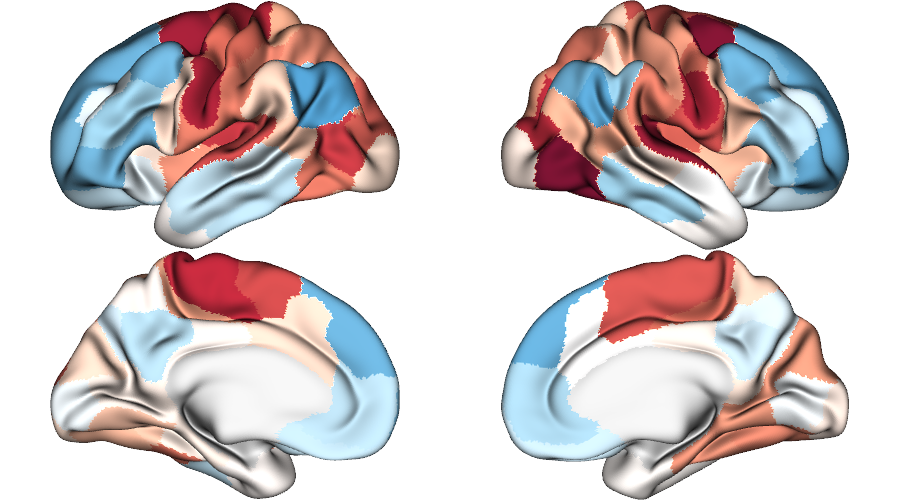

In [122]:
plot.plot_surface(
    transform.deparcellate_surf(t_age_temp, 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange='sym', cmap='RdBu_r', cbar=False,
    layout_style='grid',
)

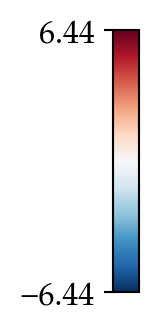

In [123]:
vmin = min(t_age_temp.values.min(), -t_age_temp.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), "RdBu_r", figsize=(2, 2));

Spatial correlation with default age effects:

In [126]:
r_aget_temp, p_aget_temp, _ = stats.spin_test_parcellated(t_age_temp.to_frame(), t_age.to_frame(), 'schaefer-100', n_perm=1000)
print(
    'Correlation coefficients\n',
    r_aget_temp,
    '\nSpin p-values\n',
    p_aget_temp
)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficients
           0
0  0.738817 
Spin p-values
      0
0  0.0


## d. Schaefer-200 (age-group-level)

Load data:

In [128]:
parcels_sch200 = transform.load_ordered_parcel_labels('schaefer-200')

if os.path.exists('pnc_fc-group_sc-micamics_sch200.csv') & os.path.exists('pnc_fc-group_sc-micamics_sch200_vars.pkz'):
    groups_optima_sch200 = pd.read_csv('pnc_fc-group_sc-micamics_sch200.csv', index_col=0)
    with open('pnc_fc-group_sc-micamics_sch200_vars.pkz', 'rb') as f:
        regional_vars_group_sch200 = pickle.load(f)
else:
    print("Run Figure 5 first")

data_group_sch200 = groups_optima_sch200.set_index('group')
data_group_sch200[['Age (y)', 'Fp']] = groups.loc[data_group_sch200.index,['age', 'F%']]
# add group-averaged motion data
data_group_sch200 = pd.concat([data_group_sch200, group_motion], axis=1)

In [129]:
S_ratio_group_sch200 = pd.DataFrame(index=data_group_sch200.index, columns=parcels_sch200, dtype=float)
for i, parc in enumerate(parcels_sch200):
    for group, row in data_group_sch200.iterrows():
        S_ratio_group_sch200.loc[group, parc] = regional_vars_group_sch200[group][row['SeedMW']].loc[i, 'S_E'] / regional_vars_group_sch200[group][row['SeedMW']].loc[i, 'S_I']

Calculate age effects:

In [130]:
df = pd.concat([S_ratio_group_sch200, data_group_sch200], axis=1)
df.columns = [f'node_{i}' for i in range(200)] + list(df.columns[200:])
df['age'] = df['Age (y)']

t_age_sch200 = pd.Series(index=parcels_sch200)
p_age_sch200 = pd.Series(index=parcels_sch200)
outliers = {}
for i, parc in enumerate(parcels_sch200):
    # fit the model
    mod = smf.ols(f'node_{i} ~ age + gof + Fp + mean_rms', data=df)
    res = mod.fit()
    t_age_sch200.loc[parc] = res.tvalues['age']
    p_age_sch200.loc[parc] = res.pvalues['age']

# FDR correction
_, p_age_sch200_fdr = statsmodels.stats.multitest.fdrcorrection(p_age_sch200)
p_age_sch200_fdr = pd.Series(p_age_group_fdr, index=parcels_sch200)


# display stats of signficant regions
stats_age_sch200 = pd.DataFrame({"t": t_age_sch200, "p": p_age_sch200, "p_fdr": p_age_sch200_fdr})
stats_age_sch200.to_csv("p_pnc_fc-group_sc-micamics_runs-1_Sratio_age_sch200_stats.csv")
stats_age_sch200[stats_age_sch200["p_fdr"] < 0.05].sort_values(by="t").round(3)

t      p  p_fdr
7Networks_LH_SomMot_6           -2.264  0.032  0.045
7Networks_RH_Vis_7              -2.036  0.052  0.010
7Networks_RH_SomMot_1           -1.043  0.307  0.022
7Networks_RH_Cont_pCun_1        -1.004  0.325  0.020
7Networks_LH_SomMot_2           -0.975  0.339  0.048
7Networks_LH_Cont_pCun_1        -0.886  0.384  0.016
7Networks_LH_Vis_7              -0.829  0.415  0.010
7Networks_LH_Default_pCunPCC_1  -0.827  0.416  0.041
7Networks_RH_Cont_PFCl_4        -0.725  0.475  0.003
7Networks_RH_Vis_8              -0.724  0.476  0.018
7Networks_RH_Default_pCunPCC_2  -0.678  0.504  0.040
7Networks_RH_SomMot_4           -0.613  0.546  0.022
7Networks_LH_Default_PFC_5      -0.586  0.563  0.003
7Networks_RH_Limbic_OFC_1       -0.571  0.573  0.003
7Networks_RH_Cont_Par_2         -0.508  0.616  0.003
7Networks_RH_Cont_PFCl_2        -0.459  0.650  0.040
7Networks_LH_Limbic_OFC_1       -0.393  0.698  0.003
7Networks_RH_Default_PFCv_1     -0.296  0.770  0.010
7Networks_LH_Default_PFC_2      -0.267  0.792  0.003
7Networks_LH_Default_Temp_2     -0.248  0.806  0.010
7Networks_LH_Cont_Par_1         -0.198  0.844  0.010
7Networks_RH_Cont_PFCl_1        -0.182  0.857  0.037
7Networks_LH_Default_PFC_7      -0.145  0.886  0.010
7Networks_RH_Vis_2              -0.070  0.945  0.050
7Networks_LH_SomMot_1           -0.049  0.962  0.040
7Networks_RH_Default_Par_1      -0.018  0.986  0.010
7Networks_LH_Default_Par_2       0.107  0.916  0.015
7Networks_LH_Limbic_TempPole_2   0.118  0.907  0.004
7Networks_RH_Cont_Par_1          0.120  0.905  0.003
7Networks_LH_Default_PFC_6       0.131  0.897  0.003
7Networks_LH_Limbic_TempPole_1   0.236  0.815  0.010
7Networks_RH_Vis_3               0.240  0.812  0.021
7Networks_LH_Default_Temp_1      0.296  0.770  0.004
7Networks_RH_Default_PFCdPFCm_2  0.332  0.743  0.003
7Networks_LH_Default_PFC_1       0.345  0.733  0.022
7Networks_LH_Vis_8               0.347  0.731  0.010
7Networks_RH_Default_PFCdPFCm_3  0.367  0.717  0.004
7Networks_RH_Default_Temp_1      0.394  0.697  0.003
7Networks_RH_Limbic_TempPole_1   0.662  0.514  0.010
7Networks_LH_Vis_1               0.815  0.422  0.022
7Networks_LH_SomMot_5            1.454  0.158  0.015
7Networks_LH_SomMot_4            2.092  0.047  0.010

Plot unthresholded:

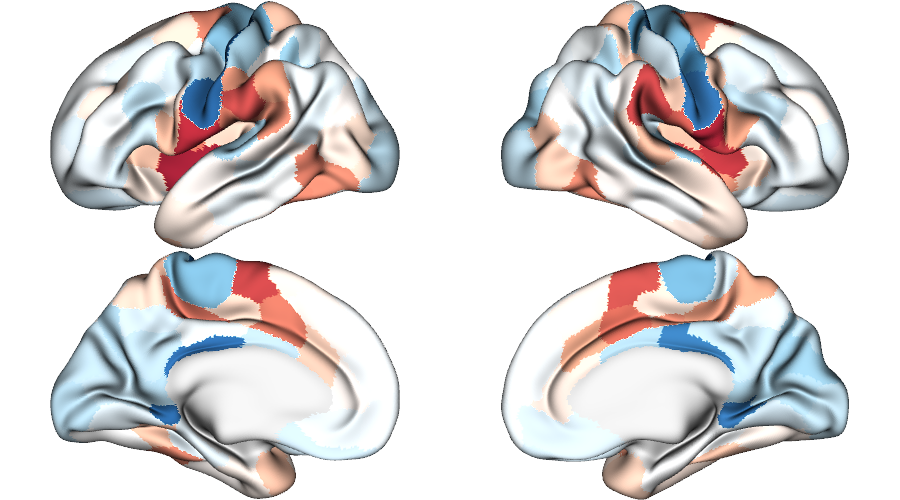

In [131]:
plot.plot_surface(
    transform.deparcellate_surf(t_age_sch200, 'schaefer-200', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange='sym', cmap='RdBu_r', cbar=False,
    layout_style='grid',
)

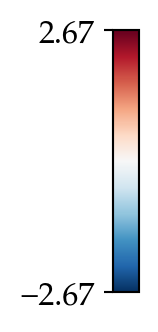

In [132]:
vmin = min(t_age_sch200.values.min(), -t_age_sch200.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), 'RdBu_r', figsize=(2, 2));

Compare with main age effect after reparcellating it to Schaefer-200 parcellation:

In [133]:
# reparcellate into schaefer-200
t_age_group_main_sch200 = transform.parcellate_surf(transform.deparcellate_surf(t_age_group, 'schaefer-100'), 'schaefer-200', concat=True).iloc[:, 0]

r_aget_group, p_aget_group, _ = stats.spin_test_parcellated(t_age_sch200.to_frame(), t_age_group_main_sch200.to_frame(), 'schaefer-200', n_perm=1000)
print(
    'Correlation coefficients\n',
    r_aget_group,
    '\nSpin p-values\n',
    p_aget_group
)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficients
           0
0  0.070197 
Spin p-values
        0
0  0.335


## e-left. Two heterogeneity maps (age-group-level)

Load data:

In [134]:
if os.path.exists('pnc_fc-group_sc-micamics_2maps.csv') & os.path.exists('pnc_fc-group_sc-micamics_2maps_vars.pkz'):
    groups_optima_2maps = pd.read_csv('pnc_fc-group_sc-micamics_2maps.csv', index_col=0)
    with open('pnc_fc-group_sc-micamics_2maps_vars.pkz', 'rb') as f:
        regional_vars_group_2maps = pickle.load(f)
else:
    print("Run Figure 5 first")

data_group_2maps = groups_optima_2maps.set_index('group')
data_group_2maps[['Age (y)', 'Fp']] = groups.loc[data_group_2maps.index,['age', 'F%']]
# add group-averaged motion data
data_group_2maps = pd.concat([data_group_2maps, group_motion], axis=1)

In [135]:
S_ratio_group_2maps = pd.DataFrame(index=data_group_2maps.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for group, row in data_group_2maps.iterrows():
        S_ratio_group_2maps.loc[group, parc] = regional_vars_group_2maps[group][row['SeedMW']].loc[i, 'S_E'] / regional_vars_group_2maps[group][row['SeedMW']].loc[i, 'S_I']

Calculate age effects:

In [136]:
df = pd.concat([S_ratio_group_2maps, data_group_2maps], axis=1)
df.columns = [f'node_{i}' for i in range(100)] + list(df.columns[100:])
df['age'] = df['Age (y)']

t_age_group_2maps = pd.Series(index=parcels)
p_age_group_2maps = pd.Series(index=parcels)
outliers = {}
for i, parc in enumerate(parcels):
    # fit the model
    mod = smf.ols(f'node_{i} ~ age + gof + Fp + mean_rms', data=df)
    res = mod.fit()
    t_age_group_2maps.loc[parc] = res.tvalues['age']
    p_age_group_2maps.loc[parc] = res.pvalues['age']

# FDR correction
_, p_age_group_2maps_fdr = statsmodels.stats.multitest.fdrcorrection(p_age_group_2maps)
p_age_group_2maps_fdr = pd.Series(p_age_group_2maps_fdr, index=parcels)

# display age effect of signficant regions
t_age_group_2maps[p_age_group_2maps_fdr<0.05].sort_values()

# display stats of signficant regions
stats_age_group_2maps = pd.DataFrame({"t": t_age_group_2maps, "p": p_age_group_2maps, "p_fdr": p_age_group_2maps_fdr})
stats_age_group_2maps.to_csv("p_pnc_fc-group_sc-micamics_runs-1_Sratio_age_2maps_stats.csv")
stats_age_group_2maps[stats_age_group_2maps["p_fdr"] < 0.05].sort_values(by="t").round(3)

Empty DataFrame
Columns: [t, p, p_fdr]
Index: []

Plot unthresholded:

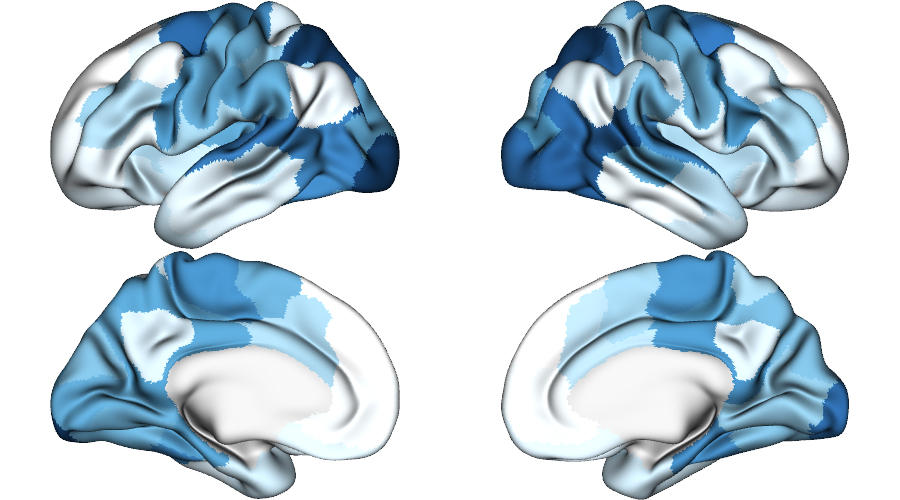

In [137]:
plot.plot_surface(
    transform.deparcellate_surf(t_age_group_2maps, 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange='sym', cmap='RdBu_r', cbar=False,
    layout_style='grid',
)

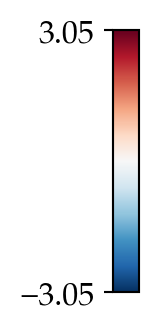

In [138]:
vmin = min(t_age_group_2maps.values.min(), -t_age_group_2maps.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), 'RdBu_r', figsize=(2, 2));

Spatial correlation with default age effects:

In [139]:
r_aget_group, p_aget_group, _ = stats.spin_test_parcellated(t_age_group_2maps.to_frame(), t_age_group.to_frame(), 'schaefer-100', n_perm=1000)
print(
    'Correlation coefficients\n',
    r_aget_group,
    '\nSpin p-values\n',
    p_aget_group
)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficients
           0
0 -0.583417 
Spin p-values
      0
0  0.0


## e-right. Four heterogeneity maps (age-group-level)

Load data:

In [140]:
if os.path.exists('pnc_fc-group_sc-micamics_4maps.csv') & os.path.exists('pnc_fc-group_sc-micamics_4maps_vars.pkz'):
    groups_optima_4maps = pd.read_csv('pnc_fc-group_sc-micamics_4maps.csv', index_col=0)
    with open('pnc_fc-group_sc-micamics_4maps_vars.pkz', 'rb') as f:
        regional_vars_group_4maps = pickle.load(f)
else:
    print("Run Figure 5 first")

data_group_4maps = groups_optima.set_index('group')
data_group_4maps[['Age (y)', 'Fp']] = groups.loc[data_group_4maps.index,['age', 'F%']]
# add group-averaged motion data
data_group_4maps = pd.concat([data_group_4maps, group_motion], axis=1)

In [141]:
S_ratio_group_4maps = pd.DataFrame(index=data_group_4maps.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for group, row in data_group_4maps.iterrows():
        S_ratio_group_4maps.loc[group, parc] = regional_vars_group_4maps[group][row['SeedMW']].loc[i, 'S_E'] / regional_vars_group_4maps[group][row['SeedMW']].loc[i, 'S_I']

Calculate age effects:

In [142]:
df = pd.concat([S_ratio_group_4maps, data_group_4maps], axis=1)
df.columns = [f'node_{i}' for i in range(100)] + list(df.columns[100:])
df['age'] = df['Age (y)']

t_age_group_4maps = pd.Series(index=parcels)
p_age_group_4maps = pd.Series(index=parcels)
outliers = {}
for i, parc in enumerate(parcels):
    # fit the model
    mod = smf.ols(f'node_{i} ~ age + gof + Fp + mean_rms', data=df)
    res = mod.fit()
    t_age_group_4maps.loc[parc] = res.tvalues['age']
    p_age_group_4maps.loc[parc] = res.pvalues['age']

# FDR correction
_, p_age_group_4maps_fdr = statsmodels.stats.multitest.fdrcorrection(p_age_group_4maps)
p_age_group_4maps_fdr = pd.Series(p_age_group_4maps_fdr, index=parcels)

# display stats of signficant regions
stats_age_group_4maps = pd.DataFrame({"t": t_age_group_4maps, "p": p_age_group_4maps, "p_fdr": p_age_group_4maps_fdr})
stats_age_group_4maps.to_csv("p_pnc_fc-group_sc-micamics_runs-1_Sratio_age_4maps_stats.csv")
stats_age_group_4maps[stats_age_group_4maps["p_fdr"] < 0.05].sort_values(by="t").round(3)

t      p  p_fdr
7Networks_RH_DorsAttn_Post_3    -3.183  0.004  0.047
7Networks_LH_Vis_1              -3.178  0.004  0.047
7Networks_LH_Default_Par_2      -3.031  0.006  0.047
7Networks_LH_Default_PFC_4      -2.993  0.006  0.047
7Networks_RH_Cont_PFCl_2        -2.965  0.007  0.047
7Networks_RH_Default_PFCv_2     -2.932  0.007  0.047
7Networks_RH_DorsAttn_Post_1    -2.923  0.007  0.047
7Networks_LH_DorsAttn_Post_5    -2.859  0.008  0.047
7Networks_LH_DorsAttn_PrCv_1    -2.848  0.009  0.047
7Networks_RH_Cont_PFCl_1        -2.839  0.009  0.047
7Networks_RH_Cont_Par_1         -2.827  0.009  0.047
7Networks_RH_Cont_Par_2         -2.795  0.010  0.047
7Networks_LH_Default_PFC_5      -2.792  0.010  0.047
7Networks_LH_Cont_PFCl_1        -2.789  0.010  0.047
7Networks_RH_Default_PFCdPFCm_2 -2.782  0.010  0.047
7Networks_LH_Limbic_TempPole_2  -2.767  0.010  0.047
7Networks_LH_Default_PFC_6      -2.765  0.011  0.047
7Networks_LH_Default_PFC_2      -2.760  0.011  0.047
7Networks_RH_Vis_1              -2.745  0.011  0.047
7Networks_LH_Cont_Par_1         -2.736  0.011  0.047
7Networks_LH_Default_Par_1      -2.732  0.011  0.047
7Networks_LH_Default_Temp_1     -2.686  0.013  0.047
7Networks_RH_Default_Temp_2     -2.680  0.013  0.047
7Networks_RH_DorsAttn_PrCv_1    -2.675  0.013  0.047
7Networks_LH_Default_PFC_7      -2.661  0.013  0.047
7Networks_RH_Default_PFCdPFCm_3 -2.653  0.014  0.047
7Networks_RH_Default_Temp_1     -2.651  0.014  0.047
7Networks_RH_Limbic_OFC_1       -2.643  0.014  0.047
7Networks_RH_Limbic_TempPole_1  -2.623  0.015  0.047
7Networks_RH_Vis_8               2.622  0.015  0.047
7Networks_LH_Vis_8               2.642  0.014  0.047

Plot unthresholded:

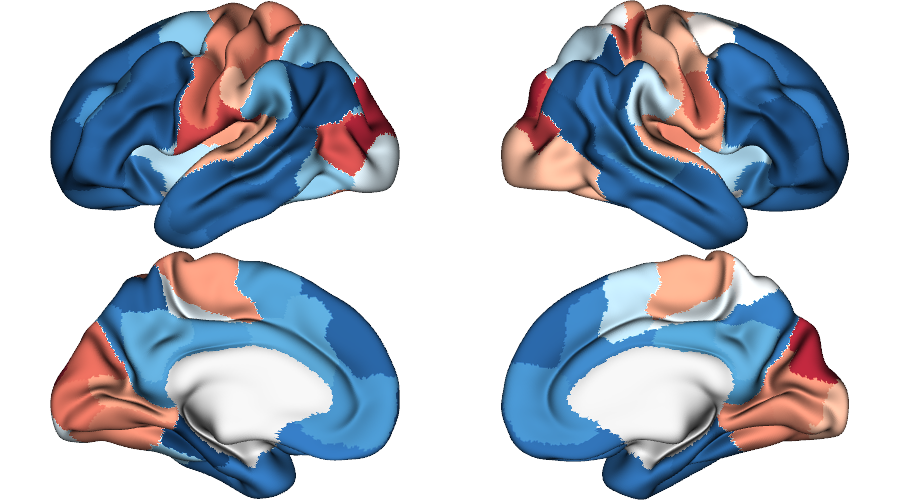

In [143]:
plot.plot_surface(
    transform.deparcellate_surf(t_age_group_4maps, 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange='sym', cmap='RdBu_r', cbar=False,
    layout_style='grid',
)

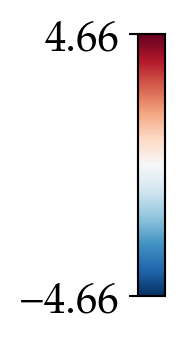

In [165]:
vmin = min(t_age_group_4maps.values.min(), -t_age_group_4maps.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), 'RdBu_r', figsize=(2, 2));

Spatial correlation with default age effects:

In [144]:
r_aget_group, p_aget_group, _ = stats.spin_test_parcellated(t_age_group_4maps.to_frame(), t_age_group.to_frame(), 'schaefer-100', n_perm=1000)
print(
    'Correlation coefficients\n',
    r_aget_group,
    '\nSpin p-values\n',
    p_aget_group
)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficients
           0
0  0.857097 
Spin p-values
      0
0  0.0


## f. Including inter-hemispheric (age-group-level)

Load data:

In [145]:
if os.path.exists('pnc_fc-group_sc-micamics_inter.csv') & os.path.exists('pnc_fc-group_sc-micamics_inter_vars.pkz'):
    groups_optima_inter = pd.read_csv('pnc_fc-group_sc-micamics_inter.csv', index_col=0)
    with open('pnc_fc-group_sc-micamics_inter_vars.pkz', 'rb') as f:
        regional_vars_group_inter = pickle.load(f)
else:
    print("Run Figure 5 first")

data_group_inter = groups_optima_inter.set_index('group')
data_group_inter[['Age (y)', 'Fp']] = groups.loc[data_group_inter.index,['age', 'F%']]
# add group-averaged motion data
data_group_inter = pd.concat([data_group_inter, group_motion], axis=1)

In [146]:
S_ratio_group_inter = pd.DataFrame(index=data_group_inter.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for group, row in data_group_inter.iterrows():
        S_ratio_group_inter.loc[group, parc] = regional_vars_group_inter[group][row['SeedMW']].loc[i, 'S_E'] / regional_vars_group_inter[group][row['SeedMW']].loc[i, 'S_I']

Calculate age effects:

In [147]:
df = pd.concat([S_ratio_group_inter, data_group_inter], axis=1)
df.columns = [f'node_{i}' for i in range(100)] + list(df.columns[100:])
df['age'] = df['Age (y)']

t_age_group_inter = pd.Series(index=parcels)
p_age_group_inter = pd.Series(index=parcels)
for i, parc in enumerate(parcels):
    # fit the model
    mod = smf.ols(f'node_{i} ~ age + gof + Fp + mean_rms', data=df)
    res = mod.fit()
    t_age_group_inter.loc[parc] = res.tvalues['age']
    p_age_group_inter.loc[parc] = res.pvalues['age']

# FDR correction
_, p_age_group_inter_fdr = statsmodels.stats.multitest.fdrcorrection(p_age_group_inter)
p_age_group_inter_fdr = pd.Series(p_age_group_inter_fdr, index=parcels)


# display stats of signficant regions
stats_age_group_inter = pd.DataFrame({"t": t_age_group_inter, "p": p_age_group_inter, "p_fdr": p_age_group_inter_fdr})
stats_age_group_inter.to_csv("p_pnc_fc-group_sc-micamics_runs-1_Sratio_age_inter_stats.csv")
stats_age_group_inter[stats_age_group_inter["p_fdr"] < 0.05].sort_values(by="t").round(3)

t      p  p_fdr
7Networks_RH_Cont_PFCl_1        -4.050  0.000  0.013
7Networks_RH_Default_PFCdPFCm_2 -3.993  0.001  0.013
7Networks_LH_Default_PFC_5      -3.928  0.001  0.013
7Networks_RH_Cont_Par_2         -3.896  0.001  0.013
7Networks_LH_Default_PFC_4      -3.824  0.001  0.013
7Networks_LH_Default_PFC_6      -3.771  0.001  0.013
7Networks_RH_Cont_PFCl_4        -3.738  0.001  0.013
7Networks_LH_Default_Par_2      -3.688  0.001  0.013
7Networks_LH_Default_PFC_2      -3.658  0.001  0.013
7Networks_RH_Cont_Par_1         -3.600  0.001  0.014
7Networks_RH_Default_Par_1      -3.538  0.002  0.015
7Networks_LH_Default_PFC_7      -3.458  0.002  0.016
7Networks_RH_Default_PFCdPFCm_3 -3.397  0.002  0.017
7Networks_LH_Cont_PFCl_1        -3.353  0.003  0.017
7Networks_RH_Limbic_OFC_1       -3.316  0.003  0.017
7Networks_RH_Default_PFCv_2     -3.313  0.003  0.017
7Networks_RH_Cont_PFCl_2        -3.298  0.003  0.017
7Networks_LH_Limbic_OFC_1       -3.275  0.003  0.017
7Networks_LH_Default_PFC_3      -3.164  0.004  0.021
7Networks_RH_Default_PFCdPFCm_1 -3.145  0.004  0.021
7Networks_RH_Cont_PFCl_3        -3.106  0.005  0.022
7Networks_RH_Default_Temp_1     -3.065  0.005  0.023
7Networks_LH_Cont_Par_1         -3.039  0.005  0.023
7Networks_LH_SalVentAttn_PFCl_1 -2.991  0.006  0.025
7Networks_LH_Limbic_TempPole_2  -2.946  0.007  0.026
7Networks_LH_Vis_1              -2.823  0.009  0.034
7Networks_LH_Default_Temp_1     -2.773  0.010  0.037
7Networks_LH_SomMot_2            2.657  0.014  0.045
7Networks_RH_DorsAttn_Post_2     2.715  0.012  0.041
7Networks_LH_DorsAttn_Post_4     3.056  0.005  0.023

Plot unthresholded:

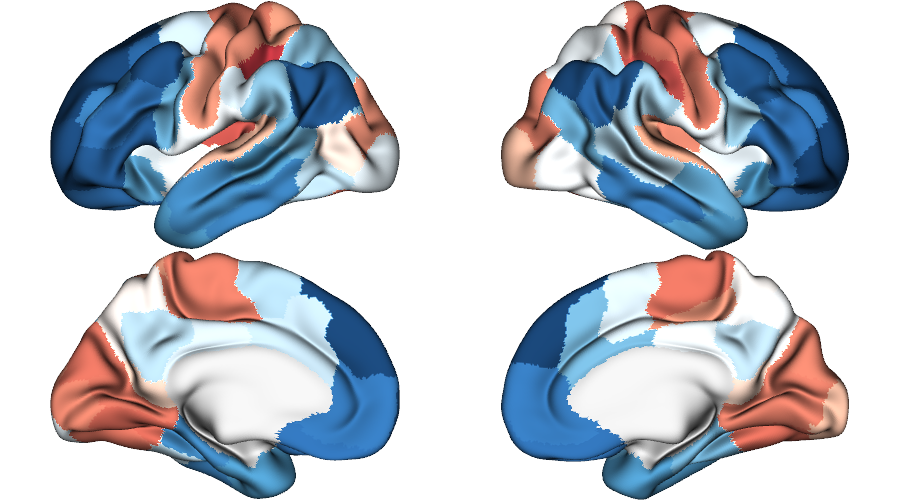

In [148]:
plot.plot_surface(
    transform.deparcellate_surf(t_age_group_inter, 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange='sym', cmap='RdBu_r', cbar=False,
    layout_style='grid',
)

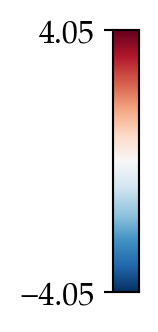

In [149]:
vmin = min(t_age_group_inter.values.min(), -t_age_group_inter.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), 'RdBu_r', figsize=(2, 2));

Spatial correlation with default age effects:

In [150]:
r_aget_group, p_aget_group, _ = stats.spin_test_parcellated(t_age_group_inter.to_frame(), t_age_group.to_frame(), 'schaefer-200', n_perm=1000)
print(
    'Correlation coefficients\n',
    r_aget_group,
    '\nSpin p-values\n',
    p_aget_group
)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficients
           0
0  0.804418 
Spin p-values
      0
0  0.0


## Text. Node-level intraclass correlation of $\frac{\langle S_i^E \rangle}{\langle S_i^I \rangle}$ across Gaussian noise random seeds

First run `scripts/modeling/run/cuBNM/sim_seed`.

Load the simulation data of alternative seeds:

In [52]:
all_seed_Sratio = {}
for sub, row in tqdm(data.iterrows()):
    cmaes_log_path = os.path.join(
        OUTPUT_DIR['pnc'], 'sim', sub, 
        'ctx_parc-schaefer-100_mean001_thresh-1_fic_final',
        '6maps_schaefer-100_zscore', 'cmaes_multimaps_gpu',
        f'ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass'\
        f'-none_exc-inter_G_0.5-4_wee_0.05-0.75_wei_0.05-0.75_wie_0_'\
        f'het-wee-wei_SeedMW-{row["SeedMW"]}_SeedSim-410_n-81x210.txt'
    )
    base_dir = cmaes_log_path.replace('.txt', '_cuBNM')
    if not os.path.exists(base_dir):
        print(sub, "not found")
        continue
    sub_Sratio = pd.DataFrame(index=parcels, columns=list(range(50))+['orig'])
    orig_sim_data = np.load(os.path.join(base_dir, 'orig', 'it1.npz'))
    sub_Sratio.iloc[:, -1] = orig_sim_data['S_E'].squeeze() / orig_sim_data['S_I'].squeeze()
    for rand_seed in range(50):
        seed_sim_data = np.load(os.path.join(base_dir, f'SeedSim-{rand_seed}', 'it1.npz'))
        sub_Sratio.iloc[:, rand_seed] = seed_sim_data['S_E'].squeeze() / seed_sim_data['S_I'].squeeze()
    all_seed_Sratio[sub] = sub_Sratio

752it [06:39,  1.88it/s]


Calculate ICC using madicc:

In [29]:
icc_seed = pd.DataFrame(index=parcels, columns=range(50), dtype=float)
for rand_seed in tqdm(range(50)):
    for i, parc in enumerate(parcels):
        icc_df = pd.DataFrame(index=data.index, columns=[1, 2], dtype=float)
        for sub in all_seed_Sratio.keys():
            icc_df.loc[sub, 'orig'] = all_seed_Sratio[sub].loc[parc, 'orig']
            icc_df.loc[sub, rand_seed] = all_seed_Sratio[sub].loc[parc, rand_seed]
        icc_seed.loc[parc, rand_seed] = utils.madicc(icc_df.loc[:, 'orig'], icc_df.loc[:, rand_seed])

100%|██████████████████████████████| 50/50 [24:58<00:00, 29.96s/it]


In [30]:
icc_seed.describe()

0           1           2           3           4           5   \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.999181    0.998964    0.999130    0.999066    0.999202    0.998729   
std      0.001059    0.001500    0.001598    0.001414    0.001101    0.002348   
min      0.994942    0.989425    0.987529    0.989240    0.994511    0.983340   
25%      0.999066    0.998714    0.998916    0.998881    0.998968    0.998619   
50%      0.999578    0.999567    0.999701    0.999404    0.999623    0.999692   
75%      0.999883    0.999871    0.999916    0.999858    0.999888    0.999873   
max      0.999996    0.999983    0.999988    0.999995    0.999988    0.999991   

               6           7           8           9   ...          40  \
count  100.000000  100.000000  100.000000  100.000000  ...  100.000000   
mean     0.998996    0.999105    0.998655    0.999203  ...    0.999066   
std      0.001358    0.001163    0.001935    0.001310  ...    0.001260   
min      0.993908    0.994898    0.989322    0.991519  ...    0.993264   
25%      0.998890    0.998731    0.998119    0.999151  ...    0.998732   
50%      0.999567    0.999569    0.999546    0.999693  ...    0.999596   
75%      0.999860    0.999912    0.999899    0.999883  ...    0.999868   
max      0.999992    0.999984    0.999992    0.999994  ...    0.999988   

               41          42          43          44          45          46  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.999228    0.999012    0.998772    0.999096    0.999125    0.999130   
std      0.001122    0.001598    0.002066    0.001507    0.001121    0.001172   
min      0.993555    0.991409    0.986369    0.988558    0.992707    0.994487   
25%      0.999051    0.998917    0.998485    0.998998    0.998777    0.998920   
50%      0.999717    0.999692    0.999694    0.999576    0.999504    0.999569   
75%      0.999893    0.999915    0.999903    0.999903    0.999923    0.999893   
max      0.999995    0.999995    0.999992    0.999995    0.999988    0.999989   

               47          48          49  
count  100.000000  100.000000  100.000000  
mean     0.999028    0.999009    0.999129  
std      0.001461    0.001334    0.001319  
min      0.992000    0.993537    0.992540  
25%      0.998762    0.998582    0.999041  
50%      0.999600    0.999526    0.999684  
75%      0.999864    0.999867    0.999898  
max      0.999991    0.999990    0.999993  

[8 rows x 50 columns]

Take median across 50 random seeds:

In [31]:
icc_seed_median = icc_seed.median(axis=1)
icc_seed_median.describe()

count    100.000000
mean       0.999470
std        0.000545
min        0.997475
25%        0.999319
50%        0.999704
75%        0.999813
max        0.999961
dtype: float64

## Text. Node-level intraclass correlation of $\frac{\langle S_i^E \rangle}{\langle S_i^I \rangle}$ across optimization runs

In [32]:
icc_opt = pd.Series(index=parcels, dtype=float)
for i, parc in enumerate(parcels):
    icc_df = pd.DataFrame(index=data.index, columns=[1, 2], dtype=float)
    for sub in data.index:
        for SeedMW in [1, 2]:
            icc_df.loc[sub, SeedMW] = regional_vars[sub][SeedMW].loc[i, 'S_E'] / regional_vars[sub][SeedMW].loc[i, 'S_I']
    icc_opt.loc[parc] = utils.madicc(icc_df.iloc[:, 0], icc_df.iloc[:, 1])

In [33]:
icc_opt.describe()

count    100.000000
mean       0.968444
std        0.011303
min        0.934015
25%        0.960885
50%        0.971154
75%        0.976681
max        0.986919
dtype: float64